# SedGen initialization

**Assumptions**
- All crystals and grains are spherical,
- Crystals cannot be smaller in diamater than 1/256 mm (clay particle threshold) 
- Crystals cannot be larger in diamater than 30 mm,
- Crystal interfaces are represented in 1-D
- Below the clay particle threshold, crystals will move to the 'residue'
- Below the kinetic energy thesholds, intra-crystal breakage will not take place anymore (Moss & Green 1975)

**Standard settings**
- lower bin size = 1/1024 mm
- upper bin size = 32 mm
- threshold for intra-crystal breakage = 1/256 mm

**Sensitivity analysis general**
- Check numerical stability of model --> how many crystals do we need in the model: 1M, 10M, 100M? Based on this number the required volume can be better constrained which is now set to 1 m³ by default.
- 

The input of data needs to be split up into two parts:
- 1. Firstly, the part of data that comes from the dataset entered into the model, this needs to be boiled down to the fundamental properties (modal mineralogy, intefacial data, and crystal size data) + properties of the environment
- 2. Secondly, for all of the parameters for which no corresponding data was entered, a substiutute needs to be constructed. For the fundamental properties this can fall back on the relations discovered during the PhD (e.g. lognormal CSD). The environmental properties might be selected by the user, nonetheless.

In [1]:
import numpy as np
import numba as nb
import numexpr as ne
import pandas as pd
import itertools
from operator import itemgetter
import gc

from scipy.stats import norm, lognorm, truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sys import getsizeof

In [2]:
from sedgen.input import Input
from sedgen.sedgen import SedGen
from sedgen import weathering
from sedgen import sedgen

In [3]:
%load_ext line_profiler
%load_ext memory_profiler

In [4]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time 
# before executing the Python code typed.
%autoreload 2

## Model input
___

### Parent rock characteristics

In [5]:
# Unit is mm³
parent_rock_volume = 1e9

In [6]:
# Mineral classes present in parent rock
# !The position of the minerals in lists/arrays should be the same 
# throughout the model!
minerals = ["Q", "P", "K", "B", "O", "A"]

### Modal mineralogy
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [7]:
# Modal mineralogy mean values per pluton of Heins(1992)
modal_mineralogy = np.array([[0.16331256, 0.46387757, 0.12683457, 0.05758711, 0.01078412, 0.17760407],   # AZ
                             [0.27453254, 0.40124204, 0.24993859, 0.02509231, 0.00454988, 0.04464465],   # CA-EW
                             [0.30591989, 0.38159713, 0.26209888, 0.0188256 , 0.00799247, 0.02356603],   # CA-NS
                             [0.19781274, 0.41766034, 0.16121575, 0.06478527, 0.00894429, 0.14958161],   # GR
                             [0.25983144, 0.46392506, 0.15827298, 0.04370113, 0.00689158, 0.06737782],   # MT
                             [0.22419158, 0.48490082, 0.05641885, 0.11571367, 0.        , 0.11877509]])  # WA

In [8]:
# Assert that modal mineralogy proportions sum up to unity.
assert all(np.isclose(np.sum(modal_mineralogy, axis=1), 1.0))

### Interfacial composition
This property will be represented by a mean value of parent rock samples.  
The mean value should be calculated based on clr transformed data, though.

In [9]:
interface_proportions_true = None

### Crystal size distributions
This property will be based on a mean crystal size and standard deviation  
which will be represented as a log-normal distribution.

In [10]:
def get_truncnorm(mean, std, trunc_left, trunc_right):
    mean = np.log(mean)
    std = np.exp(std)
    trunc_right = np.log(trunc_right)
    a, b = (trunc_left - mean) / std, (trunc_right - mean) / std
    return truncnorm(loc=mean, scale=std, a=a, b=b)

In [11]:
# Example values based on AZ from Heins(1992)
csds_AZ = np.array([
    get_truncnorm(mean=0.120, std=0.359, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.174, std=0.356, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.112, std=0.455, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.155, std=0.399, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.066, std=0.328, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.079, std=0.452, trunc_left=-np.inf, trunc_right=30),
])

In [12]:
csds_AZ_means = np.array([0.120, 0.174, 0.112, 0.155, 0.066, 0.079])
csds_AZ_stds = np.array([0.359, 0.356, 0.455, 0.399, 0.328, 0.452])

In [13]:
# Example values based on CA_NS from Heins(1992)
csds_CA_NS = np.array([
    get_truncnorm(mean=0.309, std=0.823, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.330, std=0.683, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.244, std=0.817, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.223, std=0.819, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.120, std=0.554, trunc_left=-np.inf, trunc_right=30),
    get_truncnorm(mean=0.122, std=0.782, trunc_left=-np.inf, trunc_right=30),
])

In [14]:
csds_CA_NS_means = np.array([0.309, 0.330, 0.244, 0.223, 0.120, 0.122])
csds_CA_NS_stds = np.array([0.823, 0.683, 0.817, 0.819, 0.554, 0.782])

**Remark**  
Better to put upper bin at 32 mm since crystals cannot be larger than 30 mm in diameter?  
Or keep this representation to be conform with grain size classes?

**Remark**  
Bin range should be big enough so that pd.cut() later on does not return NaN values.  
Another way to mitigate this would be to:
- Pass an lower limit to truncnorm as well OR
- simply replace any NaN values resulting from pd.cut() with the smallest size bin label, being 0

In [15]:
# Checking to see effect of number of size bins on total volume representation
stepsize = 0.015
bins = [2.0**x for x in np.arange(-17.5, 5+stepsize/2, stepsize)]

In [144]:
bins[-10:]
[2.0**x for x in np.linspace(-17.5, 5, 1501)][-10:]

[29.14143467496043,
 29.446004820013314,
 29.753758163638683,
 30.064727974866074,
 30.37894787043451,
 30.696451818426553,
 31.017274141940373,
 31.341449522800158,
 31.669013005305324,
 32.000000000018915]

[29.141434674943277,
 29.44600481999598,
 29.75375816362117,
 30.06472797484838,
 30.37894787041663,
 30.696451818408413,
 31.017274141922044,
 31.341449522781634,
 31.669013005286608,
 32.0]

In [17]:
bins_medians = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

In [18]:
len(bins)

1501

**Sensitivity analysis check**  
How many size classes are needed to correctly represent accounted modal volume?

In [104]:
np.sum(calculate_volume_sphere(np.array(bins_medians), 
                               diameter=True) * crystal_binned)

163026626.72182265

## Volume of crystals per mineral in parent rock
___
Divide 1m³ of parent rock over all mineral classes based on mineralogy

In [19]:
modal_volume = modal_mineralogy * parent_rock_volume

## Number of crystals per mineral in parent rock
___
For each mineral:  
Request crystals from CSD until accounted modal volume is filled.  
IDEA: Use pdf to speed up process.

From this, the number of crystals per mineral class will be known while   
also giving the total number of crystals (N) in 1 m³ of parent rock.

____

In [82]:
%%time
sedgen_AZ = SedGen(minerals, parent_rock_volume, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate=1000, timed=True, fast_calc=False)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 41.5353 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 85.6902 seconds
Counting interfaces...  Done in 42.5414 seconds
Correcting interface arrays for consistency...
too much Q 16
too few P -6
too few K -1
too few B -2
too few O -1
too few A -6
Initializing crystal size array... |Q|P|K|B|O|A| Done in 9.2103 seconds
Initializing inter-crystal breakage probability arrays...

---SedGen model initialization finished succesfully---
Wall time: 3min 31s


In [81]:
sedgen_AZ.minerals_N
sedgen_AZ.minerals_N_actual
sedgen_AZ.interface_counts_matrix
sedgen_AZ.interface_frequencies_corr

array([53744717, 70066921, 20272479,  7730734, 20483848, 58633643])

[53744717, 70066921, 20272479, 7730734, 20483848, 58633643]

array([[12507981., 16306624.,  4717999.,  1799168.,  4767191., 13645764.],
       [16306624., 21258924.,  6150849.,  2345573.,  6214981., 17789967.],
       [ 4717999.,  6150850.,  1779626.,   678645.,  1798182.,  5147174.],
       [ 1799168.,  2345573.,   678645.,   258795.,   685721.,  1962831.],
       [ 4767191.,  6214981.,  1798182.,   685721.,  1816930.,  5200842.],
       [13645765., 17789966.,  5147175.,  1962831.,  5200842., 14887061.]])

array([[12507972., 16306624.,  4717999.,  1799167.,  4767191., 13645764.],
       [16306622., 21258927.,  6150850.,  2345574.,  6214981., 17789967.],
       [ 4717999.,  6150850.,  1779628.,   678646.,  1798182.,  5147174.],
       [ 1799168.,  2345573.,   678645.,   258795.,   685722.,  1962831.],
       [ 4767191.,  6214981.,  1798182.,   685721.,  1816930.,  5200843.],
       [13645765., 17789966.,  5147175.,  1962831.,  5200842., 14887063.]])

In [77]:
%%time
sedgen_AZ = SedGen(minerals, parent_rock_volume, modal_mineralogy[0], csds_AZ_means, csds_AZ_stds, learning_rate=1000, timed=True)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 22.5864 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 10.8981 seconds
Counting interfaces...  Done in 42.5086 seconds
Correcting interface arrays for consistency...
Initializing crystal size array... |Q|P|K|B|O|A| Done in 48.9997 seconds
Initializing inter-crystal breakage probability arrays...

---SedGen model initialization finished succesfully---
Wall time: 2min 9s


In [15]:
%%time
sedgen_CA_NS = SedGen(minerals, parent_rock_volume, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, learning_rate=10000, timed=True, fast_calc=False, volume_binned=True)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 1.6228 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 4.3185 seconds
Counting interfaces...  Done in 1.3426 seconds
Correcting interface arrays for consistency...
too much Q 6
too few P -4
too few K -1
all good B 0
all good O 0
too few A -1
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.3390 seconds
Initializing inter-crystal breakage probability arrays...

---SedGen model initialization finished succesfully---
Wall time: 8.95 s


In [15]:
%%time
sedgen_CA_NS = SedGen(minerals, parent_rock_volume, modal_mineralogy[2], csds_CA_NS_means, csds_CA_NS_stds, learning_rate=10000, timed=True, fast_calc=False, binned=False)

---SedGen model initialization started---

Initializing modal mineralogy...
Initializing csds...
Simulating mineral occurences... |Q|P|K|B|O|A| Done in 2.0141 seconds
Initializing interfaces... |Q|P|K|B|O|A| Done in 4.5100 seconds
Counting interfaces...  Done in 1.5610 seconds
Correcting interface arrays for consistency...
too few Q -1
all good P 0
too few K -1
too much B 1
too much O 1
all good A 0
Initializing crystal size array... |Q|P|K|B|O|A| Done in 0.4422 seconds
Initializing inter-crystal breakage probability arrays...

---SedGen model initialization finished succesfully---
Wall time: 9.12 s


In [151]:
sedgen_CA_NS.crystal_size_array.nbytes / 1024**2

8.353830337524414

In [87]:
[np.sum(sedgen_CA_NS.interface_array == x) for x in range(6)]
sedgen_CA_NS.minerals_N
sedgen_CA_NS.minerals_N_actual
sedgen_CA_NS.interface_counts_matrix
sedgen_CA_NS.interface_frequencies

[2014274, 3498408, 2142133, 168736, 514546, 421529]

array([2014274, 3498408, 2142133,  168736,  514546,  421529])

[2014274, 3498408, 2142133, 168736, 514546, 421529]

array([[ 463182.,  804458.,  492583.,   38801.,  118320.,   96930.],
       [ 804459., 1397189.,  855523.,   67389.,  205498.,  168350.],
       [ 492583.,  855522.,  523850.,   41264.,  125830.,  103083.],
       [  38800.,   67390.,   41264.,    3250.,    9912.,    8120.],
       [ 118320.,  205499.,  125829.,    9912.,   30225.,   24761.],
       [  96930.,  168350.,  103083.,    8120.,   24761.,   20285.]])

array([[ 463180,  804458,  492583,   38801,  118320,   96930],
       [ 804458, 1397189,  855522,   67390,  205499,  168350],
       [ 492583,  855522,  523850,   41264,  125830,  103083],
       [  38801,   67390,   41264,    3250,    9912,    8120],
       [ 118320,  205499,  125830,    9912,   30225,   24761],
       [  96930,  168350,  103083,    8120,   24761,   20285]],
      dtype=uint32)

In [58]:
row = sedgen_CA_NS.interface_frequencies[4]
N = sedgen_CA_NS.minerals_N[4]
c = np.random.random(size=N)

In [48]:
%time tester = sedgen_CA_NS.create_transitions_per_mineral_correctly(corr=5)

|Q|2014272 2014279
[-7  0  0  0  0  0]
2014279
P|3498408 3498413
[-5  0  0  0  0  0]
3498413
K|2142132 2142138
[-6  0  0  0  0  0]
2142138
B|168737 168741
[-4  0  0  0  0  0]
168741
O|514547 514551
[-4  0  0  0  0  0]
514551
A|421529 421534
[-5  0  0  0  0  0]
421534
Wall time: 3.26 s


In [51]:
tester[1][-100:]

array([0, 1, 5, 0, 1, 2, 2, 2, 2, 1, 1, 2, 2, 4, 2, 1, 0, 1, 1, 0, 1, 1,
       4, 2, 5, 0, 2, 0, 1, 5, 1, 2, 1, 1, 0, 2, 4, 0, 1, 1, 0, 1, 0, 2,
       2, 0, 1, 0, 4, 0, 0, 1, 0, 0, 2, 0, 1, 4, 1, 2, 3, 4, 0, 0, 2, 1,
       2, 0, 5, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2,
       0, 2, 0, 1, 2, 2, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [21]:
sedgen_CA_NS.minerals_N

array([2014274, 3498408, 2142133,  168736,  514546,  421529])

In [29]:
tester[0][-10000:]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [53]:
%time sedgen.create_interface_array(sedgen_CA_NS.minerals_N, tester)

Wall time: 370 ms


array([0, 0, 2, ..., 0, 0, 0], dtype=uint8)

In [66]:
%timeit -n5 sedgen.create_transitions_correctly(row, c, N)

192 ms ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [65]:
%timeit -n5 sedgen.create_transitions_correctly(row, c, N) 

175 ms ± 6.83 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [88]:
%lprun -f sedgen.create_transitions_correctly.py_func sedgen.create_transitions_correctly.py_func(row, c, N)

Timer unit: 1e-07 s

Total time: 5.90844 s
File: d:\box sync\programming\python\jupyter_notebooks\sedgen\sedgen\src\sedgen\sedgen.py
Function: create_transitions_correctly at line 576

Line #      Hits         Time  Per Hit   % Time  Line Contents
   576                                           @nb.jit(nopython=True)
   577                                           def create_transitions_correctly(row, c, N_initial):
   578                                               """https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s
   579                                           
   580                                               Check if probs at end equals all zero to make sure function works.
   581                                               """
   582                                           
   583                                               # Absolute transition probabilities
   584         1        272.0  

____

#### Check scipy norm vs. truncnorm timings

In [17]:
%timeit norm(0, 1).rvs(1000000)
# SciPy 1.5.0

43.5 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit norm(0, 1).rvs(1000000)
# SciPy 1.3.1

39.2 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit csds_AZ[0].rvs(1000000)
# SciPy 1.5.0

85.1 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit csds_AZ[0].rvs(1000000)
# SciPy 1.3.1

123 ms ± 2.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


More time and memory efficient approach:  

**STEP A**  
Firstly, the number of minerals per mineral in 1 m³ of parent rock should be determined making use of the modal volume and CSD.

**STEP B**  
Secondly, the found N can be multiplied with the normalized pdf of the csd per a predefined number of size bins (medians).  
This than gives the number of crystals per size bin of which the sum equals N.

In [19]:
@nb.jit(nopython=True)
def calculate_volume_sphere(r, diameter=False):
    if diameter:
        r = r/2
    
    volume = 4/3 * r*r*r * np.pi
    return volume

# numba speeds up function 2x

In [20]:
@nb.jit(nopython=True)
def calculate_equivalent_circular_diameter(volume):
    diameter = 2 * (3/4 * volume / np.pi) ** (1/3)
    
    return diameter

In [21]:
def calculate_N_crystals(csd, modal_fraction, total_volume=1e9, learning_rate=100):
    total_volume_mineral = 0
    requested_volume = total_volume * modal_fraction
    # numpy.append faster than using list.extend in code
#     crystals = np.array([])
#     crystals = []
    crystals_total = []

    rs = 0 
    while total_volume_mineral < requested_volume:
        diff = requested_volume - total_volume_mineral
        crystals_requested = int(diff / (modal_fraction*learning_rate)) + 1
#         print(crystals_requested, end=" ")
        crystals_total.append(crystals_requested) 
        crystals_to_add = np.exp(csd.rvs(size=crystals_requested, random_state=rs))
#         crystals = np.append(crystals, crystals_to_add)
#         crystals.extend(crystals_to_add)
        total_volume_mineral += np.sum(calculate_volume_sphere(crystals_to_add, diameter=True))
    #     print(total_volume_mineral, "\n")
        rs += 1
    return crystals_total, np.sum(crystals_total), total_volume_mineral

**Sensitivity analysis**  
Check what is best value for learning rate based on how well modal volume is represented at end of run.  
learning_rate=1000 seems to be a good start-off point.

In [22]:
def create_N_crystals(minerals=["Q", "P", "K", "B", "O", "A"], **kwargs):
    minerals_N = {}

    for i, m in enumerate(minerals):
        print(m)
        minerals_N[m] = calculate_N_crystals(csd=kwargs["csd"][i], 
                                             modal_fraction=kwargs["modal_mineralogy"][i], 
                                             total_volume=kwargs["total_volume"], 
                                             learning_rate=kwargs["learning_rate"])
    return minerals_N

In [23]:
minerals_N = create_N_crystals(minerals=["Q", "P", "K", "B", "O", "A"],
                               csd=csds_CA_NS,
                               modal_mineralogy=modal_mineralogy[2],
                               total_volume=parent_rock_volume,
                               learning_rate=10000)

Q
P
K
B
O
A


In [22]:
# AZ
total = 0

for mineral in minerals:
    total += minerals_N[mineral][1]
    print(mineral, minerals_N[mineral][1])
print(total)

Q 53479166
P 70222320
K 20316376
B 7739862
O 20546975
A 58910729
231215428


In [98]:
# CA-EW
total = 0

for mineral in minerals:
    total += minerals_N[mineral][1]
    print(mineral, minerals_N[mineral][1])
print(total)

Q 1667333
P 3990425
K 6110871
B 333334
O 12186021
A 2064326
26352310


In [24]:
# CA-NS
total = 0

for mineral in minerals:
    total += minerals_N[mineral][1]
    print(mineral, minerals_N[mineral][1])
print(total)

Q 2014274
P 3498408
K 2142133
B 168736
O 514546
A 421529
8759626


In [107]:
# GR
total = 0

for mineral in minerals:
    total += minerals_N[mineral][1]
    print(mineral, minerals_N[mineral][1])
print(total)

Q 20711267
P 14338701
K 7941081
B 9327098
O 12571781
A 101358741
166248669


In [109]:
# MT
total = 0

for mineral in minerals:
    total += minerals_N[mineral][1]
    print(mineral, minerals_N[mineral][1])
print(total)

Q 10919323
P 26535391
K 31503060
B 8223161
O 10057995
A 6722115
93961045


In [113]:
# WA
total = 0

for mineral in minerals:
    total += minerals_N[mineral][1]
    print(mineral, minerals_N[mineral][1])
print(total)

Q 3381395
P 8182313
K 3542496
B 1488264
O 0.0
A 10381958
26976426.0


Based on 3-5 runs of above code block:  
(Without setting upper limit on CSD)   
Mineral: modal proportion #crystals in 1m³ based on CSDs for AZ, Heins(1992)  
- Q: 0.30 30-40 M  
- P: 0.35 10-15 M  
- K: 0.15  3- 5 M  
- B: 0.10  1- 4 M
- O: 0.02 23-25 M 
- A: 0.08   6-9 M

___

## Number frequency proportions
____
Based on the number of crystals per mineral, the number frequency proportions may be calculated.

In [25]:
minerals_N_total = []

for mineral in minerals:
    minerals_N_total.append(minerals_N[mineral][1])

In [26]:
number_proportions = (np.array(minerals_N_total) / np.sum(minerals_N_total)).reshape(-1, 1)
number_proportions

array([[0.22994977],
       [0.39937869],
       [0.24454617],
       [0.01926292],
       [0.05874064],
       [0.0481218 ]])

In [27]:
# Assert that number frequency proportions sum up to unity.
assert np.isclose(np.sum(number_proportions), 1.0)

## Initialize interfacial composition if not given
___
If no data on interfaces is given, the random model for interfaces may be used.   
If not, use $\alpha$ in combination with predicted interfacial composition to establish the true interfacial composition.

In [28]:
interface_proportions_pred = number_proportions * number_proportions.T
interface_proportions_pred

array([[0.0528769 , 0.09183704, 0.05623334, 0.0044295 , 0.0135074 ,
        0.0110656 ],
       [0.09183704, 0.15950334, 0.09766653, 0.0076932 , 0.02345976,
        0.01921882],
       [0.05623334, 0.09766653, 0.05980283, 0.00471067, 0.0143648 ,
        0.011768  ],
       [0.0044295 , 0.0076932 , 0.00471067, 0.00037106, 0.00113152,
        0.00092697],
       [0.0135074 , 0.02345976, 0.0143648 , 0.00113152, 0.00345046,
        0.00282671],
       [0.0110656 , 0.01921882, 0.011768  , 0.00092697, 0.00282671,
        0.00231571]])

In [29]:
# Assert that predicted interface proportions sum up to unity.
assert np.isclose(np.sum(interface_proportions_pred), 1.0)

## Initialize array representing minerals/interfaces
___
Based on the true interfacial composition, the array of minerals, representing interfaces in 1-D, may be initialized.  
This array also adheres to the number of crystals per mineral class.

In [30]:
# Use true or predicted interface proportions
if interface_proportions_true is None:
    interface_proportions = interface_proportions_pred
else:
    interface_proportions = interface_proportions_true

In [31]:
interface_proportions_normalized = np.divide(interface_proportions, np.sum(interface_proportions, axis=1).reshape(-1, 1))

In [32]:
# Assert that normalized interface proportions sum up to unity rowwise.
assert all(np.isclose(np.sum(interface_proportions_normalized, axis=1), 1))

In [33]:
def generate_transitions(minerals, random_seed=525):
    # Spike up to 1GB memory usage
    possibilities = np.arange(len(minerals), dtype=np.uint8)
    
    prng = np.random.RandomState(random_seed)

    transitions_per_mineral = []

    for i, mineral in enumerate(minerals):
        transitions_per_mineral.append(prng.choice(possibilities, minerals_N_total[i]+20000, p=interface_proportions_normalized[i]))
        
    return tuple(transitions_per_mineral)

In [34]:
%time transitions_per_mineral = generate_transitions(minerals)

Wall time: 354 ms


In [35]:
transitions_per_mineral

(array([2, 1, 2, ..., 4, 2, 0], dtype=uint8),
 array([2, 0, 2, ..., 0, 1, 0], dtype=uint8),
 array([2, 0, 1, ..., 2, 0, 1], dtype=uint8),
 array([2, 2, 1, ..., 1, 0, 1], dtype=uint8),
 array([2, 2, 2, ..., 1, 5, 0], dtype=uint8),
 array([1, 2, 1, ..., 0, 1, 2], dtype=uint8))

In [54]:
checker = count_interfaces(np.dstack((np.zeros(transitions_per_mineral[0].shape), transitions_per_mineral[0]))[0])
checker

(array([[0., 0.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 1.]]),
 array([468028, 498118,  38979, 119879,  97468, 811802], dtype=int64))

In [55]:
checker[1] / np.sum(checker[1])

array([0.23007127, 0.24486279, 0.01916114, 0.05892962, 0.04791292,
       0.39906227])

In [56]:
interface_proportions_normalized

array([[0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ]])

In [45]:
np.sum(minerals_N_total)

8759626

In [173]:
interface_frequencies = np.round(interface_proportions * (np.sum(minerals_N_total) - 1)).astype(np.uint32)
interface_frequencies

array([[ 463182,  804458,  492583,   38801,  118320,   96930],
       [ 804458, 1397189,  855522,   67390,  205499,  168350],
       [ 492583,  855522,  523850,   41264,  125830,  103083],
       [  38801,   67390,   41264,    3250,    9912,    8120],
       [ 118320,  205499,  125830,    9912,   30225,   24761],
       [  96930,  168350,  103083,    8120,   24761,   20285]],
      dtype=uint32)

In [206]:
interface_fresuencies_not_rounded = interface_proportions * (np.sum(minerals_N_total) - 1)
interface_fresuencies_not_rounded

array([[ 463181.79382249,  804458.02952476,  492582.93834223,
          38800.80026969,  118319.7217877 ,   96930.48630335],
       [ 804458.02952476, 1397189.46188734,  855522.18425098,
          67389.55577538,  205498.68650434,  168349.6826785 ],
       [ 492582.93834223,  855522.18425098,  523850.36368431,
          41263.73804364,  125830.23987414,  103083.29125852],
       [  38800.80026969,   67389.55577538,   41263.73804364,
           3250.34818218,    9911.65877908,    8119.87968711],
       [ 118319.7217877 ,  205498.68650434,  125830.23987414,
           9911.65877908,   30224.75570204,   24760.87861207],
       [  96930.48630335,  168349.6826785 ,  103083.29125852,
           8119.87968711,   24760.87861207,   20284.73333865]])

In [207]:
interface_fresuencies_not_rounded[0] / np.sum(interface_fresuencies_not_rounded[0])

array([0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
       0.0481218 ])

In [209]:
np.sum(interface_fresuencies_not_rounded[0])

2014273.770050228

In [ ]:
# Try approach where we do'nt subtract 1 from the probs every iteration of the for loop
# but 1 / minerals_N_total[i] from the probs_norm and then renormalize the probs_norm.

In [210]:
minerals_N_total

[2014274, 3498408, 2142133, 168736, 514546, 421529]

In [208]:
interface_proportions_normalized

array([[0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ],
       [0.22994977, 0.39937869, 0.24454617, 0.01926292, 0.05874064,
        0.0481218 ]])

In [211]:
interface_proportions

array([[0.0528769 , 0.09183704, 0.05623334, 0.0044295 , 0.0135074 ,
        0.0110656 ],
       [0.09183704, 0.15950334, 0.09766653, 0.0076932 , 0.02345976,
        0.01921882],
       [0.05623334, 0.09766653, 0.05980283, 0.00471067, 0.0143648 ,
        0.011768  ],
       [0.0044295 , 0.0076932 , 0.00471067, 0.00037106, 0.00113152,
        0.00092697],
       [0.0135074 , 0.02345976, 0.0143648 , 0.00113152, 0.00345046,
        0.00282671],
       [0.0110656 , 0.01921882, 0.011768  , 0.00092697, 0.00282671,
        0.00231571]])

In [201]:
463181.79382249 * (1 / (np.sum(minerals_N_total) - 1))

0.052876897563821516

In [67]:
# Every time an interface is selected, one should be subtracted from the
# probability frequency array since 'replace=False'
np.random.choice(interface_frequencies[0]

array([463182., 804458., 492583.,  38801., 118320.,  96930.])

In [120]:
probs_Q = interface_frequencies[0].copy().astype(np.uint32)

In [223]:
@nb.njit
def create_transitions_correctly(interface_frequencies, c):
    """https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s
    
    Check if probs at end equals all zero to make sure function works.
    """
    
    # Absolute transition probabilities
    probs = interface_frequencies.copy()
    probs_norm = np.divide(probs, np.sum(probs))
    # Number of transitions to obtain
    probs_sum = np.sum(probs)
    N = int(probs_sum)
    # Initalize transition array
    transitions = np.zeros(shape=N)
    
    # For every transition
    for i in range(N):
        # Create normalized probabilities
#         probs_norm = np.divide(probs, np.sum(probs))

        probs_norm /= np.sum(probs_norm)
        
        # Create cummulative probability distribution
        prob_norm_cumsum = np.cumsum(probs_norm)
        
        # Check were the random probability falls within the cumulative
        # probability distribution and select corresponding mineral
        choice = (c[i] < prob_norm_cumsum).argmax()
        
        # Assign corresponding mineral to transition array
        transitions[i] = choice

        # Remove one count of the transition probability array since we want to
        # have the exact number of absolute transitions based on the interface
        # proportions. Similar to a 'replace=False' in random sampling.
        probs_norm[choice] -= 1 / probs_sum
        probs_sum -= 1
        
    return transitions

In [220]:
interface_frequencies

array([[12690455, 22040889, 13496001,  1063081,  3241775,  2655743],
       [22040889, 38280802, 23439967,  1846368,  5630342,  4612518],
       [13496001, 23439967, 14352679,  1130562,  3447551,  2824321],
       [ 1063081,  1846368,  1130562,    89054,   271564,   222472],
       [ 3241775,  5630342,  3447551,   271564,   828111,   678409],
       [ 2655743,  4612518,  2824321,   222472,   678409,   555770]],
      dtype=uint32)

In [219]:
row

array([2655743, 4612518, 2824321,  222472,  678409,  555770], dtype=uint32)

In [215]:
checker2 = create_transitions_correctly(row, c)
checker2

In [218]:
np.bincount(checker2.astype(np.uint32))

array([2655743, 4612518, 2824321,  222472,  678409,  555770], dtype=int64)

In [222]:
count_interfaces(np.dstack((np.zeros(checker2.shape), checker2))[0])

(array([[0., 0.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 1.]]),
 array([2655743, 2824321,  222472,  678409,  555770, 4612518], dtype=int64))

In [159]:
create_transitions_correctly(row, c)

[ 96930 168350 103083   8120  24761  20285]
[0 0 0 0 0 0]


(array([0., 1., 1., ..., 2., 4., 5.]), array([0, 0, 0, 0, 0, 0], dtype=uint32))

In [224]:
interface_frequencies = np.round(interface_proportions * (np.sum(minerals_N_total) - 1)).astype(np.uint32)
interface_frequencies

array([[ 463182,  804458,  492583,   38801,  118320,   96930],
       [ 804458, 1397189,  855522,   67390,  205499,  168350],
       [ 492583,  855522,  523850,   41264,  125830,  103083],
       [  38801,   67390,   41264,    3250,    9912,    8120],
       [ 118320,  205499,  125830,    9912,   30225,   24761],
       [  96930,  168350,  103083,    8120,   24761,   20285]],
      dtype=uint32)

In [225]:
%%time
transitions_per_mineral = []

for row in interface_frequencies:
    c = np.random.random(size=np.sum(row))
    transitions_per_mineral.append(create_transitions_correctly(row, c))
    
transitions_per_mineral = tuple(transitions_per_mineral)

# Takes 1min28s to complete for 240M crystals

Wall time: 2.96 s


In [226]:
transitions_per_mineral

(array([2., 1., 2., ..., 1., 2., 0.]),
 array([1., 0., 0., ..., 4., 0., 4.]),
 array([1., 4., 0., ..., 1., 1., 0.]),
 array([0., 1., 0., ..., 4., 1., 2.]),
 array([1., 1., 3., ..., 0., 1., 2.]),
 array([3., 5., 1., ..., 1., 0., 1.]))

In [227]:
%time tester_array = generate_interface_array(transitions_per_mineral, N=np.sum(minerals_N_total))

Wall time: 96 ms


(8759626,)

In [131]:
%timeit probs_Q / np.sum(probs_Q)

7.13 µs ± 1.04 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [136]:
%timeit np.divide(probs_Q, np.sum(probs_Q))

5.54 µs ± 321 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [133]:
probs_Q / np.sum(probs_Q)

array([0.22994985, 0.39937863, 0.24454617, 0.01926302, 0.05874077,
       0.04812156])

In [ ]:
%timeit

In [100]:
p = np.array([[ 0.8 ,  0.1 ,  0.1 ],
       [ 0.3 ,  0.3 ,  0.4 ],
       [ 0.25,  0.5 ,  0.25]])

In [101]:
c = p.cumsum(axis=1)
c

array([[0.8 , 0.9 , 1.  ],
       [0.3 , 0.6 , 1.  ],
       [0.25, 0.75, 1.  ]])

In [104]:
u = np.random.rand(len(c), 1)
u

array([[0.75881542],
       [0.26640509],
       [0.38907795]])

In [105]:
choices = (u < c).argmax(axis=1)
choices

array([0, 0, 1], dtype=int64)

In [124]:
c = np.random.random(size=np.sum(probs_Q))

In [142]:
%timeit checker_Q2 = create_transitions_correctly(probs_Q, c)

688 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
%timeit checker_Q2 = create_transitions_correctly.py_func(probs_Q)

28.1 s ± 621 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
count_interfaces(np.dstack((np.zeros(checker_Q2[0].shape), checker_Q2[0]))[0])

(array([[0., 0.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 1.]]),
 array([463182, 492583,  38801, 118320,  96930, 804458], dtype=int64))

In [126]:
%lprun -f create_transitions_correctly.py_func create_transitions_correctly.py_func(probs_Q, c)

Timer unit: 1e-07 s

Total time: 50.9275 s
File: <ipython-input-123-707749b5644b>
Function: create_transitions_correctly at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @nb.njit
     2                                           def create_transitions_correctly(interface_frequencies, c):
     3                                               """https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s"""
     4         1        120.0    120.0      0.0      probs = interface_frequencies.copy()
     5         1        347.0    347.0      0.0      N = int(np.sum(probs))
     6         1       1200.0   1200.0      0.0      transitions_Q = np.zeros(shape=N)
     7                                           
     8   2014275    9250284.0      4.6      1.8      for i in range(N):
     9   2014274  245003005.0    121.6     48.1          probs_norm = probs / n

In [141]:
%lprun -f create_transitions_correctly.py_func create_transitions_correctly.py_func(probs_Q, c)

Timer unit: 1e-07 s

Total time: 50.8429 s
File: <ipython-input-140-ec662bd484ad>
Function: create_transitions_correctly at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @nb.njit
     2                                           def create_transitions_correctly(interface_frequencies, c):
     3                                               """https://stackoverflow.com/questions/40474436/how-to-apply-numpy-random-choice-to-a-matrix-of-probability-values-vectorized-s"""
     4                                               
     5                                               # Absolute transition probabilities
     6         1        104.0    104.0      0.0      probs = interface_frequencies.copy()
     7                                               # Number of transitions to obtain
     8         1        479.0    479.0      0.0      N = int(np.sum(probs))
     9                                               # Ini

In [78]:
checker_Q = count_interfaces(np.dstack((np.zeros(transitions_Q.shape), transitions_Q))[0])
checker_Q

(array([[0., 0.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 1.]]),
 array([463182, 492583,  38801, 118320,  96930, 804458], dtype=int64))

In [64]:
index = tuple(np.random.randint(0, 6, 2))
index

(5, 5)

In [ ]:
test_array = np.zeros(int(minerals_N_total), dtype=np.uint8)
index = tuple(np.random.randint(0, 6, 2))
index

test_array[0] = index[0]
test_array

for i in np.sum(minerals_N_total):
    test_array[i] = interface_frequencies[index]

In [149]:
@nb.jit(nopython=True)
def generate_interface_array(interfaces_random, N=200e6, print_step=1000000):
    
    # It's faster to work with list here and convert it to array afterwards
    # 1m13s + 20s compared to 1m45s
    # True, but the list implementation uses around 9 GB memory while
    # the numpy one uses ca. 220 MB as per the array initialization.
    # The time loss of working with a numpy array from the start is 
    # around 10 s compared to the list implementation.
    test_array = np.zeros(int(N), dtype=np.uint8)
#     test_array = [0]
#     append_ = test_array.append
    counters = np.array([0, 0, 0, 0, 0, 0], dtype=np.uint32)
#     array_size_range = range(test_array.shape[0])
    array_size_range = range(int(N))

    for i in array_size_range:
        previous_state = test_array[i-1]
        test_array[i] = interfaces_random[previous_state][counters[previous_state]]
#         append_(interfaces_random[previous_state][counters[previous_state]])
        counters[previous_state] += 1
#         if i % print_step == 0:
#             print(i, end=" ")
            
    return test_array

# Numba provides a ca. 80x times speedup
# 1.2s compared to 1m45s

In [51]:
%time tester_array = generate_interface_array(transitions_per_mineral, N=np.sum(minerals_N_total))

Wall time: 292 ms


In [45]:
# Slower than np.bincount but less memory usage.
# Can use up to 1 GB memory for 230 M crystals
%time np.unique(tester_array, return_counts=True)

Wall time: 175 ms


(array([0, 1, 2, 3, 4, 5], dtype=uint8),
 array([2013358, 3499000, 2143818,  167848,  514737,  420865], dtype=int64))

In [228]:
# FASTEST way of counting number frequencies of minerals
# Can use up to 2 GB memory for 230 M crystals
# Doesn't return unique entries, though, as np.unique does.
%time np.bincount(tester_array)

Wall time: 55 ms


array([2014273, 3498408, 2142132,  168737,  514547,  421529], dtype=int64)

In [181]:
# FASTEST way of counting number frequencies of minerals
# Can use up to 2 GB memory for 230 M crystals
# Doesn't return unique entries, though, as np.unique does.
%time np.bincount(tester_array)

Wall time: 55 ms


array([2014276, 3498406, 2142132,  168737,  514547,  421528], dtype=int64)

In [184]:
tester_array.shape

(8759626,)

In [186]:
sum(minerals_N_total)

8759626

In [183]:
minerals_N_total

[2014274, 3498408, 2142133, 168736, 514546, 421529]

In [52]:
# FASTEST way of counting number frequencies of minerals
# Can use up to 2 GB memory for 230 M crystals
# Doesn't return unique entries, though, as np.unique does.
%time np.bincount(tester_array)

Wall time: 60 ms


array([2013358, 3499000, 2143818,  167848,  514737,  420865], dtype=int64)

In [229]:
# Create array of interfaces
# Faster than np.stack()
# 440 MB memory usage
%time tester_interfaces_array = np.dstack((tester_array[:-1], tester_array[1:]))[0]

Wall time: 17 ms


In [188]:
def count_interfaces(A):
    """Count number frequencies of crystal interfaces
    https://stackoverflow.com/questions/16970982/find-unique-rows-in-numpy-array/16973510"""

    b = np.ascontiguousarray(A).view(np.dtype((np.void, A.dtype.itemsize * A.shape[1])))
    unq_a, unq_cnt = np.unique(b, return_counts=True)
    unq_a = unq_a.view(A.dtype).reshape(-1, A.shape[1])

    return unq_a, unq_cnt

# Numba does not yet support the return_counts keyword argument of 
# np.unique, unfortunately.

In [230]:
# Uses around 800 MB of memory to calculate, frees up afterwards.
%time interface_counts = count_interfaces(tester_interfaces_array)

Wall time: 1.37 s


In [146]:
interface_counts

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [232]:
interface_counts_matrix = interface_counts[1].reshape(6, -1)
interface_counts_matrix

array([[ 463181,  804458,  492582,   38801,  118320,   96930],
       [ 804458, 1397189,  855522,   67390,  205499,  168350],
       [ 492583,  855522,  523850,   41264,  125830,  103083],
       [  38801,   67390,   41264,    3250,    9912,    8120],
       [ 118320,  205499,  125830,    9912,   30225,   24761],
       [  96930,  168350,  103083,    8120,   24761,   20285]],
      dtype=int64)

In [233]:
interface_frequencies - interface_counts_matrix

array([[1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [58]:
def vec_translate(a, my_dict):    
    """Map a dictionary to a numpy array"""
    return np.vectorize(my_dict.__getitem__)(a)

In [59]:
# Create dictionary of labels for interfaces
# Not sure if this will be used actually
labels_numbered = list(itertools.product('012345', repeat=2))
labels_mapping = {"".join(k): v for k,v in zip(labels_numbered, range(36))}

___
**At this point, SedGen is just below 1 GB (1010 MB) in memory size for AZ.**
**180 MB for CA-NS**
___

## Create 1-D array of crystal sizes
____
A connection between the matrix of crystal sizes and the array of minerals/interfaces has to be made.  
For this purpose, put the matrix of crystal sizes also in a 1-D array format according to the ordering  
of the minerals/interfaces array while respecting the number of crystals per size bin for each mineral class

## Probability arrays for inter-crystal breakage
___
The location of inter-crystal breakage at each time step will be affected by the following probability arrays:
- Array of location of interfaces within the poly-crystalline grain: outer crystals will have higher probability than inner ones.
- Array of interface strengths: the higher the strength, the less likely the interface will fail.
- Array of interface sizes: the larger the interface surface, the easier it will fail (cfr. breaking large vs. small wooden stick)

### Location of interfaces

In [92]:
def create_interface_location_prob(a):
    """Creates an array descending and then ascending again to represent 
    chance of inter crystal breakage of a poly crystalline grain (pcg).
    The outer interfaces have a higher chance of breakage than the 
    inner ones based on their location within the pcg.
    This represents a linear function.
    Perhaps other functions might be added (spherical) to see the effects later on
    """
    size, corr = divmod(len(a), 2)
#     print(size)
#     print(corr)
    ranger = np.arange(size, 0, -1, dtype=np.uint32)
#     print(ranger[-2+corr::-1])
    chance = np.append(ranger, ranger[-2+corr::-1])
    
    return chance

# Not worth it adding numba to this function

In [61]:
%timeit create_interface_location_prob(tester_array)

48.9 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [220]:
%timeit create_interface_location_prob.py_func(tester_array)

46.2 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
# Test
create_interface_location_prob(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

array([5, 4, 3, 2, 1, 2, 3, 4, 5], dtype=uint32)

In [62]:
# Array takes up 878 MB of memory
%time interface_location_prob = create_interface_location_prob(tester_array)

Wall time: 48 ms


In [56]:
interface_location_prob.shape

(8759625,)

In [57]:
tester_array.shape

(8759626,)

In [58]:
np.sum(interface_location_prob)

1442350845

### Strength of interfaces

In [63]:
%%time
# Get array of interface strengths
# Note that true matrix of interface strengths still needs to be added 
# and the interface proportions are used here as a substitute.
# Array takes up 1756 MB of memory.
interface_strengths = interface_proportions_normalized[tester_interfaces_array[:, 0], tester_interfaces_array[:, 1]]

Wall time: 108 ms


### Size of interfaces
pd.cut() does not return all possible bins (even though some may be empty) as does np.histogram!

In [52]:
# An array of crystal sizes cfr. the array of minerals/interfaces still 
# has to be created.
# The number of crystals per mineral class could be multiplied with the 
# normalized binned pdf of the CSDs
# to obtain the matrix of crystal sizes from which we can choose.
# So we would have to generate m arrays of crystal size labels.
# From these arrays the array of crystal sizes cfr. interfaces array may
# be filled.

# In this way we end up with an array crystal sizes that have the 
# crystals randomly distributed according to size but they adhere to the
# number frequency and interfacial proportions.

In [60]:
minerals_N_total

[2014274, 3498408, 2142133, 168736, 514546, 421529]

In [64]:
minerals_N_total_actual = [np.sum(tester_array == i) for i in range(len(minerals))]
minerals_N_total_actual

[2013358, 3499000, 2143818, 167848, 514737, 420865]

In [65]:
def create_binned_crystal_size_arrays(csd, minerals_N_total_actual, bins, minerals=["Q", "P", "K", "B", "O", "A"], random_seed=434):
    # Arrays in list take up 440 MB of memory in total.
    crystal_size_random = []

    for i, mineral in enumerate(minerals):
        crystal_size_random.append(np.array(pd.cut(np.exp(csd[i].rvs(minerals_N_total_actual[i], random_state=random_seed)), 
                                                   bins=bins, 
                                                   labels=range(len(bins)-1), 
                                                   right=False),
                                           dtype=np.uint16))
    return crystal_size_random

In [66]:
%time crystal_size_random = create_binned_crystal_size_arrays(csds_CA_NS, minerals_N_total_actual, bins=bins)

Wall time: 2.06 s


In [66]:
crystal_size_random[0]

array([ 966,  942,  998, ..., 1381,  771, 1007], dtype=uint16)

In [67]:
def fill_main_cystal_size_array(crystal_size_random, tester_array):
    """After pre-generation of random crystal_sizes has been performed,
    the sizes are allocated according to the mineral order in the
    minerals/interfaces array
    """
    # Array takes up 440 MB of memory but is only fully present in memory 
    # after assigning values to it other than zero in next cell.
    crystal_size_array = np.zeros(tester_array.shape, dtype=np.uint16)
    
    # Much faster way (6s) to create crystal size labels array than to use 
    # modified function of interfaces array creating (1m40s)!!
    for i in range(len(minerals)):
        crystal_size_array[np.where(tester_array == i)[0]] = crystal_size_random[i]
    
    return crystal_size_array

In [68]:
%time crystal_size_array = fill_main_cystal_size_array(crystal_size_random, tester_array)

Wall time: 260 ms


(array([9.0000000e+00, 1.3200000e+03, 7.0772000e+04, 1.6275770e+06,
        1.5442831e+07, 5.9527905e+07, 9.0568409e+07, 5.1698118e+07,
        1.1072526e+07, 8.6655400e+05]),
 array([   0. ,  149.3,  298.6,  447.9,  597.2,  746.5,  895.8, 1045.1,
        1194.4, 1343.7, 1493. ]),
 <a list of 10 Patch objects>)

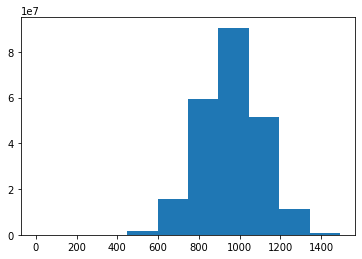

In [291]:
# AZ
plt.hist(crystal_size_array)

(array([1.250000e+02, 1.892000e+03, 1.845900e+04, 1.246330e+05,
        5.379230e+05, 1.454142e+06, 2.397533e+06, 2.333975e+06,
        1.380022e+06, 4.981720e+05]),
 array([   0. ,  149.3,  298.6,  447.9,  597.2,  746.5,  895.8, 1045.1,
        1194.4, 1343.7, 1493. ]),
 <a list of 10 Patch objects>)

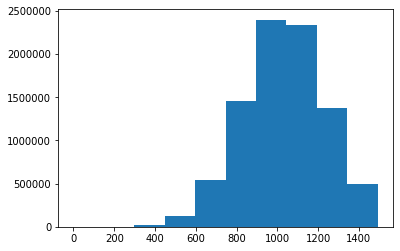

In [91]:
# CA-NS
plt.hist(crystal_size_array)

In [69]:
%%time
# This approach can be used to set op probability array for 
# inter-crystal breakage representing interface size between crystals.
# Array takes up 440 MB of memory.
interfaces_size_prob = np.min(np.dstack((crystal_size_array[:-1], crystal_size_array[1:])), axis=-1)[0]
# Since this represents probabilities, we don't want zeros as a possible
# values bit a 0 bin exists.
# Therefore all values are raised by 1 to go around this issue.
interfaces_size_prob += 1

Wall time: 46 ms


In [81]:
# This operation would reduce array's memory usage with a factor 4.
# Instead of 1756 MB it would take up 440 MB of memory.
interface_strengths.astype(np.float16)

array([0.2288, 0.3997, 0.2288, ..., 0.3997, 0.2429, 0.3997], dtype=float16)

In [67]:
gc.get_count()

(157, 7, 5)

In [68]:
gc.collect()

5443

In [66]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size_ in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size_)))

                           _44: 69.1 MiB
                           _23: 35.3 KiB
                           _24: 35.3 KiB
                          _i52:  5.1 KiB
                          _i49:  5.1 KiB
                          _i58:  5.1 KiB
                          _i61:  5.1 KiB
                          _i32:  5.1 KiB
                          _i37:  5.1 KiB
                          _i54:  5.1 KiB


___
**SedGen takes up just below 5 GB of memory (4962 MB) at this point for AZ.**
**350 MB for CA-NS.**
___

## Current variables
___

Now we have access to the following variables:
- Modal mineralogy
- Interfacial composition
- Interface strengths
- CSD
- Parent rock volume
- Number frequencies
- Array of minerals/interfaces
- Array of crystal size labels
- Array of interface locations
- Array of interface sizes
- Array of interface strengths

## Mechanical weathering

### Inter-crystal breakage

For every iteration of the for loop there is a chance that every present pcg might be broken into two new pcg.  
The chance of breakage depends on the arrays of:
- interface locations
- interface sizes
- interface strengths

Every iteration a check for mcg should be done as they need to be transferred from the pcg array to the mcg matrix based on mineral class and size bin.


In [97]:
tester_array[:100]

array([2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 0, 0, 2, 5, 1, 2, 1, 0, 2, 1, 2, 5, 2, 0, 2, 1,
       0, 2, 4, 1, 1, 2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 2,
       2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 4, 4, 0, 1, 1, 2, 0, 1, 1, 4, 2,
       0, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 1], dtype=uint8)

In [98]:
crystal_size_array[:100]

array([1015,  493,  599, 1121, 1041, 1227,  728, 1216, 1239, 1037,  920,
       1297,  893,  998, 1257,  916, 1193, 1091, 1153,  735,  658, 1158,
        936,  968, 1070,  951,  999,  713, 1078, 1142, 1036,  676, 1078,
       1297, 1152,  748,  522,  746,  964, 1075,  478, 1148, 1126,  977,
        910, 1073, 1052, 1017,  961,  821, 1132,  893, 1083, 1187,  915,
        954,  888, 1077,  989, 1196, 1199,  896,  621, 1188,  847,  855,
        953, 1189, 1169, 1103, 1035,  833,  909, 1326,  805,  823,  989,
       1166, 1017,  927, 1052,  974, 1142,  491,  858,  957,  889, 1167,
        679,  958, 1047,  910, 1096,  852, 1143, 1122, 1007,  881, 1074,
       1130], dtype=uint16)

In [216]:
interface_location_prob[:10]
interface_strengths[:10]
interfaces_size_prob[:10]

array([4373438, 4373437, 4373436, 4373435, 4373434, 4373433, 4373432,
       4373431, 4373430, 4373429], dtype=uint32)

array([0.24268882, 0.40218828, 0.40218828, 0.24268882, 0.40218828,
       0.40218828, 0.24268882, 0.24268882, 0.40218828, 0.22910523])

array([ 493,  493,  599, 1041, 1041,  728,  728, 1216, 1037,  920],
      dtype=uint16)

In [217]:
tester_array.shape

(8746876,)

In [218]:
interface_location_prob.shape
interface_strengths.shape
interfaces_size_prob.shape

(8746875,)

(8746875,)

(8746875,)

In [219]:
# Array takes up 1756 MB of memory.
prob = interface_location_prob * interface_strengths * interfaces_size_prob

In [220]:
# Array takes up 1756 MB of memory.
prob_normalized = prob / np.sum(prob)

In [221]:
np.min(prob_normalized)
np.max(prob_normalized)

0.0

5.189285157354286e-07

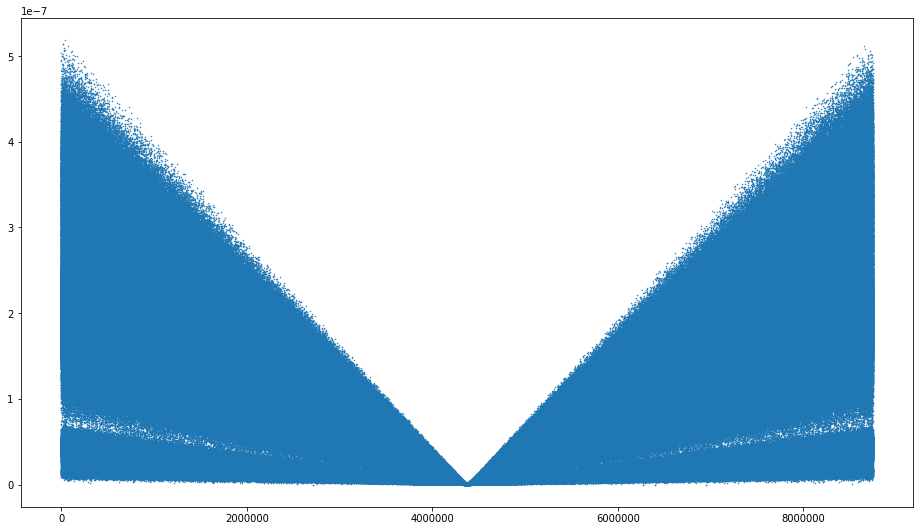

In [222]:
# CA-NS
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(prob_normalized, linestyle='None', marker='.', markersize=1)
plt.show();

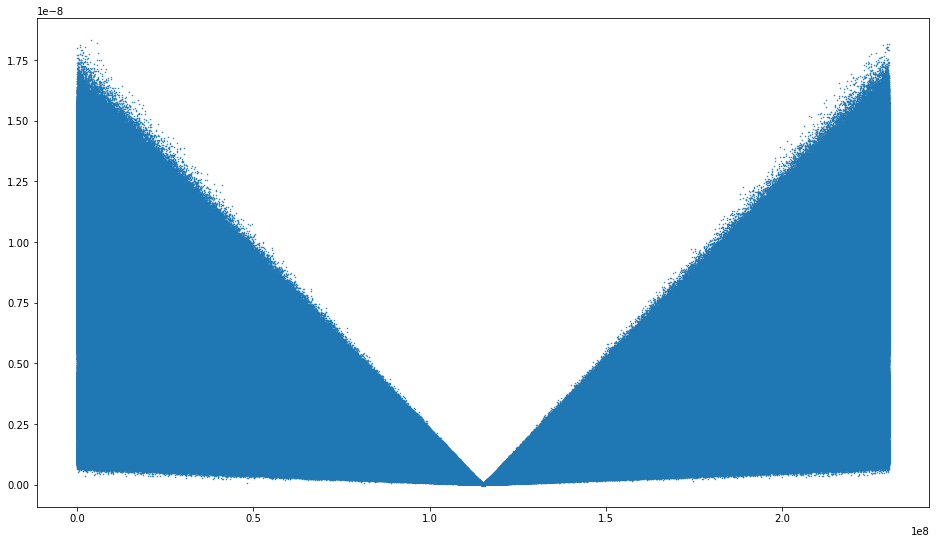

In [113]:
# AZ
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(prob_normalized, linestyle='None', marker='.', markersize=1)
plt.show();

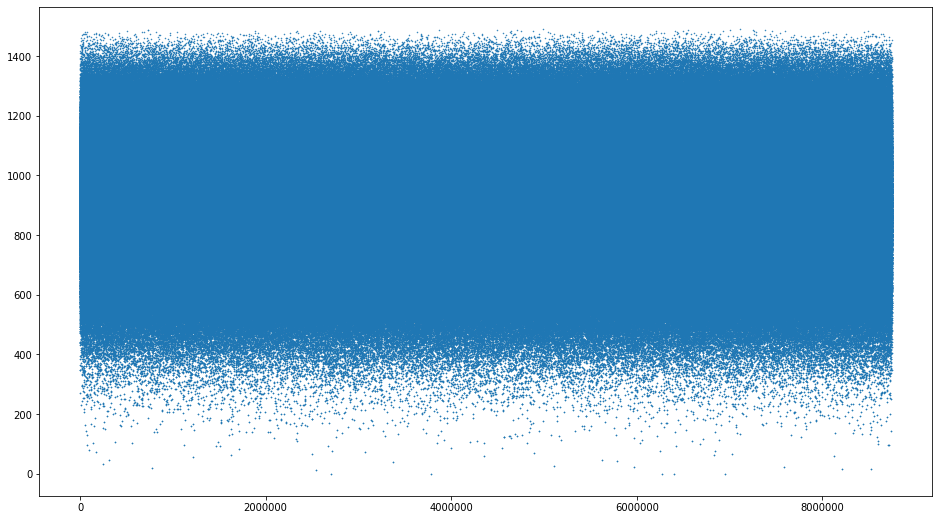

In [223]:
# CA-NS
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(interfaces_size_prob, linestyle='None', marker='.', markersize=1)
plt.show();

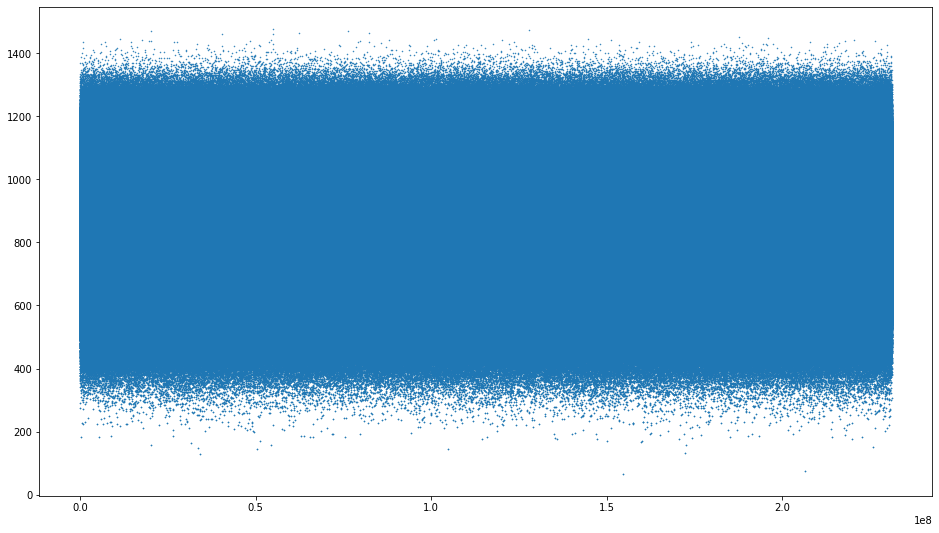

In [114]:
# AZ
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(interfaces_size_prob, linestyle='None', marker='.', markersize=1)
plt.show();

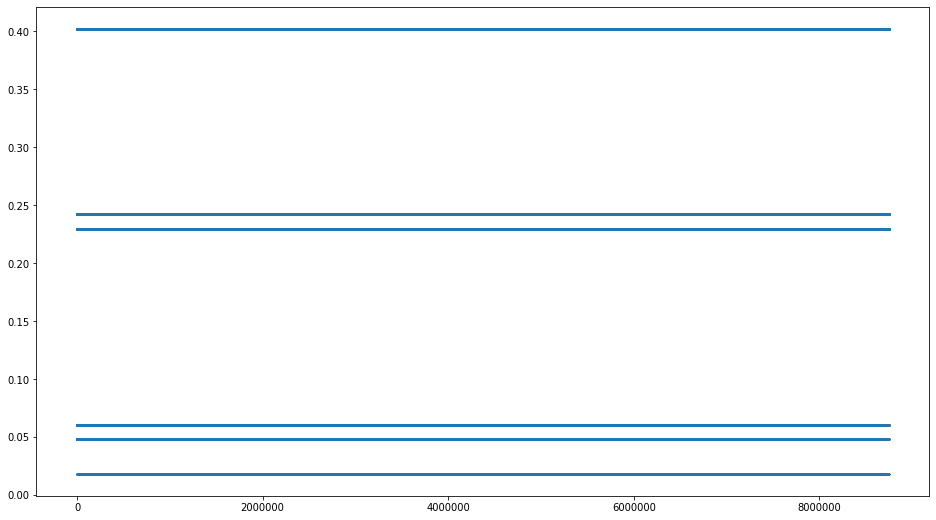

In [224]:
# CA-NS
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(interface_strengths, linestyle='None', marker='.', markersize=1)
plt.show();

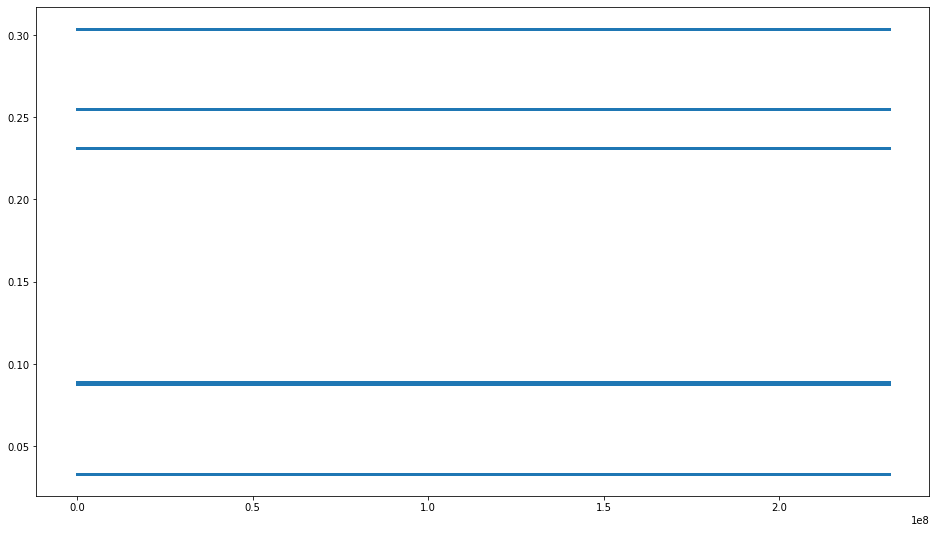

In [116]:
# AZ
fig, ax = plt.subplots(figsize=(16, 9))
plt.plot(interface_strengths, linestyle='None', marker='.', markersize=1)
plt.show();

In [ ]:
# The interface_strengths and interface_size_prob arrays never change,
# except for removing interfaces when splitting,
# as opposed to the interface_location_prob which changes every time
# the array is split. 

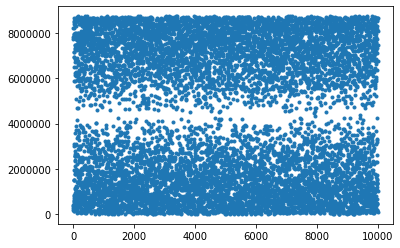

In [249]:
plt.plot(np.random.choice(len(tester_array)-1, size=10000, p=prob_normalized), linestyle='None', marker='.')

In [124]:
np.random.choice(len(tester_array)-1, size=1, p=prob_normalized)

array([6025461])

___

## inter-crystal breakage mockup example
____

**Still need to keep track of various parameters' evolution:**
- interfaces_counts
- pcg_array
- mcg_array

In [16]:
def create_interface_location_prob(a):
    """Creates an array descending and then ascending again to represent 
    chance of inter crystal breakage of a poly crystalline grain (pcg).
    The outer interfaces have a higher chance of breakage than the 
    inner ones based on their location within the pcg.
    This represents a linear function.
    Perhaps other functions might be added (spherical) to see the effects later on
    """
    size, corr = divmod(len(a), 2)
#     print(size)
#     print(corr)
    ranger = np.arange(size, 0, -1, dtype=np.uint32)
#     print(ranger[-2+corr::-1])
    chance = np.append(ranger, ranger[-2+corr::-1])
    
    return chance

# Not worth it adding numba to this function

In [17]:
# Speedup from 6m30s to 2m45s
@nb.njit
def select_interface(i, probs, c):
    interface = (c[i] < np.cumsum(probs)).argmax() + 1
    
    return interface

In [18]:
# Speedup from 2m45s to 1m30s
@nb.njit
def calculate_normalized_probability(location_prob, prob):
    probability = location_prob * prob
    return probability / np.sum(probability)

In [311]:
a = np.zeros((6, 1500))

In [296]:
rr, cc = np.broadcast_arrays(1,0)
flat_index = rr*a.shape[1] + cc
a.take(flat_index)

# a = a.flatten()

3

In [293]:
a[flat_index] = 5

In [308]:
rows = np.array([1])
cols = np.array([0])

In [314]:
%timeit a[1, 0] += 1

570 ns ± 33.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [315]:
%timeit (a.ravel()[(cols + (rows * a.shape[1]).reshape((-1,1))).ravel()])[0] += 1

5.65 µs ± 685 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [319]:
def inter_crystal_breakage(crystal_array, crystal_size_array, 
                           interface_counts_matrix, n_timesteps,
                           interfaces_size_prob, interface_strengths, minerals,
                           bins=None, verbose=False, random_seed=343, n_standard_cases=2000, p=[0.5], intra_cb_thresholds=[1/256]):

    prng = np.random.RandomState(random_seed)
    
    interface_constant_prob = ne.evaluate("interfaces_size_prob * interface_strengths")
    standard_prob_loc_cases = np.array([create_interface_location_prob(np.arange(x)) for x in range(2000)])
        
    pcgs_new = [crystal_array.copy()]
    interface_constant_prob_new = [interface_constant_prob.copy()]
    crystal_size_array_new = [crystal_size_array.copy()]
    interface_counts = interface_counts_matrix.copy()

    mcg = np.zeros((len(minerals), len(bins)), dtype=np.uint32)
#     mcg = [[] for i in range(len(minerals))]
    residue = np.zeros(len(minerals), dtype=np.float64)
    residue_count = np.zeros(len(minerals), dtype=np.uint32)
    
    # Create array of intra-crystal brekage probabilities
    if len(p) == 1:
        p = np.array([p] * len(minerals))
    elif len(p) == len(minerals):
        p = np.array(p)
    else:
        raise ValueError("p should be of length 1 or same length as minerals")
        
    # Create array of intra-cyrstal breakage size thresholds
    if len(intra_cb_thresholds) == 1:
        intra_cb_thresholds = np.array([intra_cb_thresholds] * len(minerals))
    elif len(intra_cb_thresholds) == len(minerals):
        intra_cb_thresholds = np.array(intra_cb_thresholds)
    else:
        raise ValueError("intra_cb_thresholds should be of length 1 or same length as minerals")
    
    pcg_additions = np.zeros(n_timesteps, dtype=np.uint32)
    mcg_additions = np.zeros(n_timesteps, dtype=np.uint32)
    mcg_broken_additions = np.zeros(n_timesteps, dtype=np.uint32)
    residue_additions = np.zeros(n_timesteps, dtype=np.float64)
    residue_count_additions = np.zeros(n_timesteps, dtype=np.uint32)
    
    pcg_comp_evolution = []
    pcg_size_evolution = []

    for step in range(n_timesteps):
                    
        # intra-crystal breakage
#         mcg_old = [np.array(m, dtype=np.float64) for m in mcg]  # to change?
#         print(mcg_old)
#         mcg_broken, residue, residue_count = intra_crystal_breakage(mcg_old, p, residue, residue_count)
        mcg_broken, residue, residue_count = intra_crystal_breakage_binned(mcg, p, intra_cb_thresholds, residue, residue_count)
        mcg_broken_additions[step] = np.sum([np.sum(x) for x in mcg_broken])
        residue_additions[step] = np.sum(residue)
        residue_count_additions[step] = np.sum(residue_count)
        mcg = mcg_broken
        
        print(f"{step}/{n_timesteps}", end="\r", flush=True)
        pcgs_old = pcgs_new
        pcgs_new = []
        pcgs_new_append = pcgs_new.append

        interface_constant_prob_old = interface_constant_prob_new
        interface_constant_prob_new = []
        interface_constant_prob_new_append = interface_constant_prob_new.append

        crystal_size_array_old = crystal_size_array_new
        crystal_size_array_new = []
        crystal_size_array_new_append = crystal_size_array_new.append
        
        
        c_creator = np.random.RandomState(step)
        c = c_creator.random(size=pcg_additions[step-1] + 1)

        
        if verbose:
            print("pcgs_old_size", len(pcgs_old))

        for i, (pcg, prob, csize) in enumerate(zip(pcgs_old, interface_constant_prob_old, crystal_size_array_old)):
            
            # Select interface for inter-crystal breakage
            try:
                location_prob = standard_prob_loc_cases[len(pcg)]
            except IndexError:
                location_prob = create_interface_location_prob(pcg)
                
#             probability = location_prob * prob
#             probability_normalized = probability / np.sum(probability)
            
            probability_normalized = \
                calculate_normalized_probability(location_prob, prob)
    
            # The '+ 1' makes sure that the first interface can also be selected
            # This also results in that if the final crystal is selected,
            # the pcg will not be broken in two.
#             interface = prng.choice(len(pcg)-1, size=None, p=probability_normalized) + 1
#             print(interface)
            
            interface = select_interface(i, probability_normalized, c)
#             interface = (c[i] < np.cumsum(probability_normalized)).argmax() + 1
#             print(interface)

            # We have to make sure the returned splitted array has only
            # one dimension. If the pcg happens to be split in half,
            # we end up with two arrays of the same size and Numpy will
            # happiliy put them in 2-D matrix format for us, but in this case
            # that is unwanted behavior.

            # Using indexing instead of np.split is faster
            # Also avoids the problem described above
            # How this effects memory usage is still unknown.
            new_pcgs = [pcg[:interface], pcg[interface:]]
            new_csizes = [csize[:interface], csize[interface:]]
            new_probs = [prob[:interface-1], prob[interface:]]

            # Add new pcg to pcg array or to mcg array
            for (new_pcg, new_csize, new_prob) in zip(new_pcgs, new_csizes, new_probs):
                if new_pcg.size != 1:  # This implies that len(new_prob) != 0
                    pcgs_new_append(new_pcg)
                    crystal_size_array_new_append(new_csize)
                    interface_constant_prob_new_append(new_prob)
                else:
                    mcg[new_pcg[0], new_csize[0]] += 1
#                     mcg[new_pcg[0]].append(new_csize[0])

            # remove interface from interface_counts_matrix
#             rr, cc = np.broadcast_arrays(r,c)
            interface_counts[new_pcgs[0][-1], new_pcgs[1][0]] -= 1

        if verbose:
            print("\n")
            print(np.sum(mcg), "-", np.sum(mcg_additions))
            print("\n")
        
        pcg_additions[step] = len(pcgs_new)
#         n_mcg = 0
#         for m in mcg:
#             n_mcg += len(m)
        mcg_additions[step] = np.sum(mcg) - np.sum(mcg_additions)
#         mcg_additions[step] = n_mcg - np.sum(mcg_additions)
        
        pcg_comp_evolution.append(pcgs_new)
        pcg_size_evolution.append(crystal_size_array_new) 
        
        if not pcgs_new: # Faster to check if pcgs_new has any items
            print(f"After {step} steps all pcg have been broken down to mcg")
            break
    
    return pcgs_new, mcg, pcg_additions, mcg_additions, pcg_comp_evolution, pcg_size_evolution, interface_counts, crystal_size_array_new, mcg_broken_additions, residue_additions, residue_count_additions

In [152]:
def intra_crystal_breakage(mcg_old, p, residue, residue_count):
    # Initialize new mcg array and residue array
    mcg_new = []
    
    for i, m_old in enumerate(mcg_old):
        if len(m_old) == 0:
            mcg_new.append([])
        else:
            m_new, residue_new, residue_count_new = perform_intra_crystal_breakage.py_func(i, m_old, p)
            mcg_new.append(list(m_new))
            residue[i] += residue_new
            residue_count[i] += residue_count_new
    return mcg_new, residue, residue_count

In [20]:
@nb.njit
def perform_intra_crystal_breakage(i, m_old, p):
    # Create binary array to select crystals that will be broken
    selection = np.random.binomial(1, p[i], m_old.size) == 1
    n_not_selected = np.sum((selection == 0))
    #         print(len(m_old) + np.sum(selection))

    m_new = np.zeros(shape=len(m_old) + np.sum(selection), dtype=np.float64)
    #         print(m_new.shape)
    #         print(np.sum(selection))
    #         print(np.sum(selection == False))

    # Add non-selected crystals to m_new array
    m_new[:n_not_selected] = m_old[~selection]

    # Get diameters of selected crystals
    selected_diameters = m_old[selection]

    # Calculate volume of crystals that will break
    selected_volumes = sedgen.calculate_volume_sphere(selected_diameters, diameter=True)

    # Create [0, 1] array to determine where crystals will break
    cutter = np.random.random(selected_volumes.size)

    # Break crystals by dividing the volume according to [0, 1] array
    broken_volumes_1 = selected_volumes * cutter
    broken_volumes_2 = selected_volumes * (1 - cutter)

    broken_volumes = np.concatenate((broken_volumes_1, broken_volumes_2))

    # Calculate corresponding crystal diameter (and size bin)
    broken_diameters = sedgen.calculate_equivalent_circular_diameter(broken_volumes)

    # Add newly formed mcg to m_new array
    m_new[n_not_selected:] = broken_diameters
        # If newly formed crystal is smaller than smallest size bin
        # volume should be added to residue array
    # Threshold value based on clay particle diameter (8 on phi scale)
    condition = m_new > 0.00390625
    m_new_filtered = m_new[condition]
    residue_new = np.sum(sedgen.calculate_volume_sphere(m_new[~condition], diameter=True))
    residue_count = m_new[~condition].size
    return m_new_filtered, residue_new, residue_count

In [233]:
def intra_crystal_breakage_binned(mcg_old, p, intra_cb_thresholds, residue, residue_count):
    mcg_new = np.zeros_like(mcg_old)
#     print(mcg_old.shape)
    for i, m_old in enumerate(mcg_old):
#         print(m_old.shape)
        if all(m_old == 0):
            mcg_new[i] = m_old
        else:
            m_new, residue_new, residue_count_new = perform_intra_crystal_breakage_binned(m_old, p, intra_cb_thresholds, i)
            mcg_new[i] = m_new
            residue[i] += residue_new
            residue_count[i] += residue_count_new
    return mcg_new, residue, residue_count

In [267]:
# Approach for one mineral class m of mcg
bins_medians_volumes = sedgen_CA_NS.volume_bins_medians.copy()
bins = sedgen_CA_NS.volume_bins.copy()

@nb.njit(cache=True)
def perform_intra_crystal_breakage_binned(tally, p, intra_cb_thresholds, i, indices=indices, residue_threshold=1/1024):
#     rng = np.random.default_rng(seed=random_seed)
#     print(tally.dtype)
    
    # Filter bins below intra-crystal breakage threshold
    binlabel_at_threshold = (bins > sedgen.calculate_volume_sphere(intra_cb_thresholds[i])).argmax() - 1
    tally_above_threshold = tally[binlabel_at_threshold:]
    tally_below_threshold = np.zeros_like(tally, dtype=np.uint32)
    tally_below_threshold[:binlabel_at_threshold] = tally[:binlabel_at_threshold]
#     print(np.sum(tally_below_threshold[:binlabel_at_threshold]))
    
    n_mcg = np.sum(tally_above_threshold)
    
    # Order selection according to positioning in m array
    indices = np.arange(binlabel_at_threshold, bins_medians_volumes.size)
#     print(indices)
    tally_flat = np.repeat(indices, tally_above_threshold)
    # Get binomial selection
#     selection = np.random.binomial(1, p, n_mcg) == 1
#     random_floats = rng.random(n_mcg)
    random_floats = np.random.random(n_mcg)
    selection = random_floats > p[i]
    
    n_selected = np.sum(selection)
    n_not_selected = n_mcg - n_selected
    
    mcg_new = np.zeros(shape=n_mcg+n_selected, dtype=np.uint16)
    # Perform selection of m array based on ordered selection array
    selected_items = tally_flat[selection]
    # Non selected diamaters should remain in new mcg array
    mcg_new[:n_not_selected] = tally_flat[~selection]
    # Get cutter according
    cutter = random_floats[:n_selected]
    
    # Get selected volumes based on bins_medians_volumes
    selected_volumes = bins_medians_volumes[selected_items]
    # Multiply cutter with correct index (= volume class) of binned_medians_volumes
    # Multiply (1 -cutter) with correct index (= volume class) of binned_medians_volumes
    broken_volumes_1 = selected_volumes * cutter
    broken_volumes_2 = selected_volumes - broken_volumes_1
    broken_volumes = np.concatenate((broken_volumes_1, broken_volumes_2))
    
    # Check for values that should be moved to residue array based on 
    # threshold value
    residue_condition = broken_volumes > sedgen.calculate_volume_sphere(residue_threshold)
    
    broken_volumes_filtered = broken_volumes[residue_condition]
    n_selected_filtered = len(broken_volumes_filtered)
    residue = broken_volumes[~residue_condition]
    residue_count = len(residue)
    residue = np.sum(residue)
    
    # Calculate diamaters of filtered broken volumes
    # This step is not needed as size_bins and volume_bins are the same except
    # for the fact that they represent the proporty of size in a different
    # dimension
#     broken_diameters = sedgen.calculate_equivalent_circular_diameter(broken_volumes_filtered)
    # Bin broken diameters according to bins of model
#     broken_diameters_binned = np.digitize(broken_diameters, bins=bins) - 1
    broken_diameters_binned = np.digitize(broken_volumes_filtered, bins=bins) - 1
    
    # Correct for values that fall outside of leftmost bin
    # This should not be a problem here, however, as during the residue check
    # all values smaller than the leftmost bin have been moved from the broken
    # array to the residue array
    broken_diameters_binned[broken_diameters_binned > len(bins)] = 0
    
    # Add filtered broken diamaters to mcg_new array
    mcg_new[n_not_selected:n_not_selected+n_selected_filtered] = broken_diameters_binned
    
    # Remove non-used items from array
    mcg_new = np.delete(mcg_new, slice(n_not_selected+n_selected_filtered, len(mcg_new)))
    
    # Obtain new tally array
    tally_new = np.zeros(bins_medians_volumes.size, dtype=np.uint32)
    tally_count = np.bincount(mcg_new)
    tally_new[:len(tally_count)] = tally_count
    
    # Add unaffected tally below intra_cb_threshold to new tally
    tally_new += tally_below_threshold
    
    return tally_new, residue, residue_count

In [279]:
%%time
pcgs_new, mcg, pcg_additions, mcg_additions, pcg_comp_evolution, pcg_size_evolution, interface_counts, crystal_size_array_new, mcg_broken_additions, residue_additions, residue_count_additions = \
    inter_crystal_breakage(sedgen_CA_NS.interface_array, sedgen_CA_NS.crystal_size_array, sedgen_CA_NS.interface_counts_matrix,\
                           40, sedgen_CA_NS.interface_size_prob, sedgen_CA_NS.interface_strengths_prob, sedgen_CA_NS.minerals, verbose=False, bins=sedgen_CA_NS.volume_bins_medians, intra_cb_thresholds=[1/256])

Wall time: 5min 4s


In [320]:
%lprun -f inter_crystal_breakage \
    inter_crystal_breakage(sedgen_CA_NS.interface_array, sedgen_CA_NS.crystal_size_array, sedgen_CA_NS.interface_counts_matrix,\
                           40, sedgen_CA_NS.interface_size_prob, sedgen_CA_NS.interface_strengths_prob, sedgen_CA_NS.minerals, verbose=False, bins=sedgen_CA_NS.volume_bins_medians, intra_cb_thresholds=[1/256])

Timer unit: 1e-07 s

Total time: 485.249 s
File: <ipython-input-319-f3329c294a0b>
Function: inter_crystal_breakage at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def inter_crystal_breakage(crystal_array, crystal_size_array, 
     2                                                                      interface_counts_matrix, n_timesteps,
     3                                                                      interfaces_size_prob, interface_strengths, minerals,
     4                                                                      bins=None, verbose=False, random_seed=343, n_standard_cases=2000, p=[0.5], intra_cb_thresholds=[1/256]):
     5                                           
     6         1       2931.0   2931.0      0.0      prng = np.random.RandomState(random_seed)
     7                                               
     8         1     130143.0 130143.0      0.0      interface_constant_prob

In [ ]:
# Different approach for pcg and mcg?

# Perform function per mineral class
def chemical_weathering_mcg(mcg_old):
    # Create selection array based on chemical weathering importance
    
    # Select mcg
    # Keep nont selected mcg in their respective size/volume bins
    
    # Reduce size/volume of selected mcg by decreasing their size/volume bin by one
    # In reality this is equal to reducing the volume of the mcg by 2%
    
    # Concatenate non affected mcg with chemical weathered mcg
    
    return mcg_new

In [280]:
mcg_broken_additions

array([        0,         0,         0,         0,         0,         0,
               0,         0,         4,        42,       128,       420,
            1211,      3195,      7760,     16829,     34632,     67569,
          125518,    224602,    388144,    652296,   1070558,   1723096,
         2723947,   4242426,   6519910,   9908590,  14907239,  22244933,
        32949021,  48490145,  70970019, 103333395, 149770911, 216138203,
       310660606, 444782026, 634435162, 901660452], dtype=uint32)

In [270]:
mcg_additions

array([       0,        0,        0,        0,        0,        0,
              0,        2,       23,       47,      170,      450,
           1097,     2507,     4747,     8920,    15946,    26456,
          42913,    67373,   102531,   152877,   223990,   320977,
         452654,   629967,   866184,  1177436,  1587589,  2120861,
        2821120,  3728319,  4905237,  6414592,  8357400, 10833222,
       13980521, 17959211, 22964208, 29216844], dtype=uint32)

In [276]:
mcg[0, :201]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   1,   0,   0,
         0,   0,   0,   0,   1,   0,   0,   1,   1,   0,   1,   1,   0,
         2,   0,   0,   1,   0,   2,   0,   1,   0,   0,   1,   1,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   0,
         0,   1,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1,
         0,   3,   0,   2,   0,   1,   0,   0,   1,   0,   0,   

In [321]:
sedgen_CA_NS.volume_bins[:-2] / sedgen_CA_NS.volume_bins[2:]

array([0.95926412, 0.95926412, 0.95926412, ..., 0.95926412, 0.95926412,
       0.95926412])

In [278]:
sedgen_CA_NS.volume_bins[1:] / sedgen_CA_NS.volume_bins[:-1]

array([1.02101213, 1.02101213, 1.02101213, ..., 1.02101213, 1.02101213,
       1.02101213])

In [231]:
mcg[:, 200:]

array([[345350, 345650, 344057, ...,      0,      0,      0],
       [750775, 749517, 751037, ...,      0,      0,      0],
       [368663, 366880, 367475, ...,      0,      0,      0],
       [ 18741,  18829,  18784, ...,      0,      0,      0],
       [ 74198,  73645,  74126, ...,      0,      0,      0],
       [ 51497,  51679,  51513, ...,      0,      0,      0]],
      dtype=uint32)

In [204]:
1/256

0.00390625

In [189]:
mcg_broken_additions

array([       0,        0,        0,        0,        0,        0,
              0,        0,        3,       37,      112,      400,
           1161,     3041,     7384,    15859,    32385,    62962,
         116446,   206992,   355294,   592384,   963464,  1535183,
        2399625,  3689787,  5593255,  8376270, 12406976, 18203267],
      dtype=uint32)

In [191]:
residue_count_additions

array([      0,       0,       0,       0,       0,       0,       0,
             0,       0,       3,       8,      18,      58,     122,
           306,     718,    1587,    3256,    6405,   12170,   22364,
         40130,   69688,  119101,  200675,  333761,  548171,  889460,
       1428224, 2269283], dtype=uint32)

In [182]:
mcg_additions

array([      0,       0,       0,       0,       0,       0,       0,
             2,      25,      57,     208,     548,    1327,    3060,
          6082,   11947,   22209,   39304,   67250,  112450,  181911,
        289341,  454351,  702302, 1071996, 1623863, 2438691, 3638263,
       5396566, 7968541], dtype=uint32)

In [163]:
%debug

> <ipython-input-148-be144efe024e>(25)perform_intra_crystal_breakage_binned()
     23     mcg_new = np.zeros(shape=n_mcg+n_selected, dtype=np.uint16)
     24     # Perform selection of m array based on ordered selection array
---> 25     selected_items = tally_flat[selection]
     26     # Non selected diamaters should remain in new mcg array
     27     mcg_new[:n_not_selected] = tally_flat[~selection]



ipdb>  tally_flat


array([472])


ipdb>  selection


array([[False],
       [False],
       [False],
       [False],
       [False],
       [False]])


ipdb>  quit()


In [22]:
tally_test_big = np.random.randint(0, 50000, 1500)
tally_test_big

array([37083,  9080,  4203, ..., 14103, 37237, 15177])

In [263]:
%time perform_intra_crystal_breakage_binned(tally_test_big, p=np.array([0.5]), intra_cb_thresholds=np.array([1/4]), i=0)

int32
[ 800  801  802  803  804  805  806  807  808  809  810  811  812  813
  814  815  816  817  818  819  820  821  822  823  824  825  826  827
  828  829  830  831  832  833  834  835  836  837  838  839  840  841
  842  843  844  845  846  847  848  849  850  851  852  853  854  855
  856  857  858  859  860  861  862  863  864  865  866  867  868  869
  870  871  872  873  874  875  876  877  878  879  880  881  882  883
  884  885  886  887  888  889  890  891  892  893  894  895  896  897
  898  899  900  901  902  903  904  905  906  907  908  909  910  911
  912  913  914  915  916  917  918  919  920  921  922  923  924  925
  926  927  928  929  930  931  932  933  934  935  936  937  938  939
  940  941  942  943  944  945  946  947  948  949  950  951  952  953
  954  955  956  957  958  959  960  961  962  963  964  965  966  967
  968  969  970  971  972  973  974  975  976  977  978  979  980  981
  982  983  984  985  986  987  988  989  990  991  992  993  994  995


(array([37083,  9080,  4203, ...,  8100, 19282,  7771], dtype=uint32), 0.0, 0)

In [248]:
%time perform_intra_crystal_breakage_binned.py_func(tally_test_big, p=np.array([0.5]), intra_cb_thresholds=np.array([1/256]), i=0)

int32
Wall time: 4.44 s


(array([37445,  9504,  4611, ...,  8244, 19391,  7721], dtype=uint32),
 4.565010311037076e-06,
 18602)

In [242]:
%debug

> <ipython-input-240-fcdede8ec18c>(84)perform_intra_crystal_breakage_binned()
     82 
     83     # Add unaffected tally below intra_cb_threshold to new tally
---> 84     tally_new += tally_below_threshold
     85 
     86     return tally_new, residue, residue_count



ipdb>  tally_new.dtype


dtype('uint32')


ipdb>  tally_below_threshold.dtype


dtype('int32')


ipdb>  quit()


In [121]:
%timeit perform_intra_crystal_brakage_binned(tally_test_big, p=0.5)

3.14 s ± 88.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit perform_intra_crystal_brakage_binned(tally_test_big, p=0.5)

3.28 s ± 84.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%timeit perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

5.48 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
50000*1500

75000000

In [48]:
%timeit np.random.binomial(1, 0.5, 75000000)

1.65 s ± 75.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%timeit np.random.random(75000000) > 0.5

865 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
rng = np.random.default_rng()

In [69]:
%timeit rng.integers(0, 100, 75000000, dtype=np.uint8) > 50

842 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%timeit rng.random(75000000) > 0.5

631 ms ± 29.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [74]:
%timeit np.random.random(75000000) > 0.5

890 ms ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
@nb.njit(parallel=True, fastmath=True)
def rando(n):
    return np.random.random(n)

In [84]:
%timeit rando(75000000)

230 ms ± 8.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%timeit np.random.binomial(1, 0.5, 75000000) == 1

1.68 s ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%timeit random_selection = np.where(np.random.random(1000000) > 0.5)[0]

17.4 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
random_selection = np.random.random(1000000) > 0.5

In [115]:
items = sedgen_CA_NS.crystal_size_array[:1000000].copy()

In [131]:
%%timeit
selected = items[random_selection]
not_selected = items[~random_selection]

11.3 ms ± 454 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [118]:
%%timeit
selected = np.take(items, random_selection)
not_selected = np.take(items, ~random_selection)

13.8 ms ± 667 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [132]:
%timeit selected, non_selected = items[random_selection], items[~random_selection]

11.8 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [132]:
%timeit selected, non_selected = np.compress(itemsrandom_selection], items[~random_selection]

11.8 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [137]:
%timeit np.compress(random_selection, items)

7.4 ms ± 370 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [136]:
%timeit items[random_selection]

5.26 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [128]:
np.where(np.random.random(1000000) > 0.5)

ValueError: either both or neither of x and y should be given

In [ ]:
np.take()

In [139]:
%lprun -f perform_intra_crystal_brakage_binned.py_func perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 4.64022 s
File: <ipython-input-138-86e36a45a57c>
Function: perform_intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit(cache=True, parallel=True)
     7                                           def perform_intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices, random_seed=343):
     8                                           #     rng = np.random.default_rng(seed=random_seed)
     9                                               
    10         1        612.0    612.0      0.0      n_mcg = np.sum(tally)
    11                                               
    12                                               # Order selection according to positioning in m array
    13         1    1832347.0 1832347.0      3.9      tally_flat = np.repeat(indices, tally)
    14                                               # Get binomial selecti

In [94]:
%lprun -f perform_intra_crystal_brakage_binned.py_func perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 4.69591 s
File: <ipython-input-93-eb2f793cb2c2>
Function: perform_intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit(parallel=True)
     7                                           def perform_intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices, random_seed=343):
     8                                           #     rng = np.random.default_rng(seed=random_seed)
     9                                               
    10         1        495.0    495.0      0.0      n_mcg = np.sum(tally)
    11                                               
    12                                               # Order selection according to positioning in m array
    13         1    1779318.0 1779318.0      3.8      tally_flat = np.repeat(indices, tally)
    14                                               # Get binomial selection
    15    

In [73]:
%lprun -f perform_intra_crystal_brakage_binned.py_func perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 4.68619 s
File: <ipython-input-71-2537cefb2b1f>
Function: perform_intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit(parallel=True)
     7                                           def perform_intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices, random_seed=343):
     8                                           #     rng = np.random.default_rng(seed=random_seed)
     9                                               
    10         1        415.0    415.0      0.0      n_mcg = np.sum(tally)
    11                                               
    12                                               # Order selection according to positioning in m array
    13         1    1893896.0 1893896.0      4.0      tally_flat = np.repeat(indices, tally)
    14                                               # Get binomial selection
    15    

In [67]:
%lprun -f perform_intra_crystal_brakage_binned.py_func perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 4.68639 s
File: <ipython-input-66-04561026125a>
Function: perform_intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit(parallel=True)
     7                                           def perform_intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices, random_seed=343):
     8         1       1591.0   1591.0      0.0      rng = np.random.default_rng(seed=random_seed)
     9                                               
    10         1        628.0    628.0      0.0      n_mcg = np.sum(tally)
    11                                               
    12                                               # Order selection according to positioning in m array
    13         1    1693035.0 1693035.0      3.6      tally_flat = np.repeat(indices, tally)
    14                                               # Get binomial selection
    15      

In [65]:
%lprun -f perform_intra_crystal_brakage_binned.py_func perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 4.76596 s
File: <ipython-input-64-927aceb5b1ea>
Function: perform_intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit(parallel=True)
     7                                           def perform_intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices, random_seed=343):
     8         1       1455.0   1455.0      0.0      rng = np.random.default_rng(seed=random_seed)
     9                                               
    10         1        400.0    400.0      0.0      n_mcg = np.sum(tally)
    11                                               
    12                                               # Order selection according to positioning in m array
    13         1    1753842.0 1753842.0      3.7      tally_flat = np.repeat(indices, tally)
    14                                               # Get binomial selection
    15      

In [44]:
%lprun -f perform_intra_crystal_brakage_binned.py_func perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 5.25846 s
File: <ipython-input-43-f376a72fd09b>
Function: perform_intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit(parallel=True)
     7                                           def perform_intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices):
     8         1        583.0    583.0      0.0      n_mcg = np.sum(tally)
     9                                               
    10                                               # Order selection according to positioning in m array
    11         1    1692194.0 1692194.0      3.2      tally_flat = np.repeat(indices, tally)
    12                                               # Get binomial selection
    13         1    8260790.0 8260790.0     15.7      selection = np.random.binomial(1, p, n_mcg) == 1
    14                                               
    15         1     3832

In [47]:
%lprun -f perform_intra_crystal_brakage_binned.py_func perform_intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 5.59106 s
File: <ipython-input-45-001ead560714>
Function: perform_intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit(parallel=True)
     7                                           def perform_intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices):
     8         1        431.0    431.0      0.0      n_mcg = np.sum(tally)
     9                                               
    10                                               # Order selection according to positioning in m array
    11         1    2027167.0 2027167.0      3.6      tally_flat = np.repeat(indices, tally)
    12                                               # Get binomial selection
    13         1    8960688.0 8960688.0     16.0      selection = np.random.binomial(1, p, n_mcg) == 1
    14                                               
    15         1     3861

In [35]:
np.min(sedgen_CA_NS.crystal_size_array)

3.5312762542544707e-06

In [156]:
mcg_random = [sedgen_CA_NS.crystal_size_array[:1000000], sedgen_CA_NS.crystal_size_array[1000000:2000000], sedgen_CA_NS.crystal_size_array[2000000:3000000], 
              sedgen_CA_NS.crystal_size_array[3000000: 3500000], sedgen_CA_NS.crystal_size_array[3500000:4000000], sedgen_CA_NS.crystal_size_array[:4000000]]

In [121]:
mcg_random

[array([0.40780325, 0.38090598, 0.15669453, ..., 2.14641329, 0.09761075,
        8.2167103 ]),
 array([0.06754839, 1.59315573, 1.02038885, ..., 1.86825919, 0.01626636,
        0.10964186]),
 array([2.92033625, 0.75697239, 0.24684065, ..., 0.01073774, 0.01938568,
        0.51330594]),
 array([1.60530402, 4.51043026, 0.04915142, ..., 0.38942824, 0.05737612,
        0.00502808]),
 array([ 0.02294084, 12.70934115,  0.31846276, ...,  0.02490788,
         1.08349848,  1.27108573]),
 array([0.40780325, 0.38090598, 0.15669453, ..., 0.02490788, 1.08349848,
        1.27108573])]

In [133]:
%timeit tester = intra_crystal_breakage(mcg_random, p=np.array([0.5, 0.6, 0.4, 0.5, 0.55, 0.65]))

710 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [135]:
%timeit tester = intra_crystal_breakage(mcg_random, p=np.array([0.5, 0.6, 0.4, 0.5, 0.55, 0.65]))

737 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [157]:
tester = intra_crystal_breakage(mcg_random, p=np.array([0.5, 0.6, 0.4, 0.5, 0.55, 0.65]))

In [140]:
%lprun -f intra_crystal_breakage intra_crystal_breakage(mcg_random, p=np.array([0.5, 0.6, 0.4, 0.5, 0.55, 0.65]))

Timer unit: 1e-07 s

Total time: 0.782157 s
File: <ipython-input-134-2a5ffc792fd9>
Function: intra_crystal_breakage at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def intra_crystal_breakage(mcg_old, p):
     2                                               # Initialize new mcg array and residue array
     3         1         15.0     15.0      0.0      mcg_new = []
     4                                           #     residue = []
     5                                               
     6         7        108.0     15.4      0.0      for i, m_old in enumerate(mcg_old):
     7         6    7821003.0 1303500.5    100.0          m_new = perform_inter_crystal_breakage.py_func(i, m_old, p)
     8         6        433.0     72.2      0.0          mcg_new.append(m_new)
     9         1          8.0      8.0      0.0      return mcg_new

In [100]:
%lprun -f intra_crystal_breakage.py_func intra_crystal_breakage.py_func(np.array([mcg_random]), p=np.array([0.5]))

Timer unit: 1e-07 s

Total time: 0.894025 s
File: <ipython-input-94-b258751ffa64>
Function: intra_crystal_breakage at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           @nb.njit
     2                                           def intra_crystal_breakage(mcg_old, p):
     3                                               # Initilize new mcg array and residue array
     4         1         31.0     31.0      0.0      mcg_new = []
     5                                           #     residue = []
     6                                               
     7         2        130.0     65.0      0.0      for i, m_old in enumerate(mcg_old):
     8                                                   
     9                                                   
    10                                                   # Create binary array to select crystals that will be broken
    11         1    2320717.0 2320717.0     26.0        

In [36]:
tester_array = sedgen_CA_NS.crystal_size_array[:1000000].copy()
tester_array

array([ 871, 1009,  841, ...,  884,  533,  962], dtype=uint16)

In [37]:
c = np.random.random(1000000)

In [39]:
selected_volumes = sedgen_CA_NS.volume_bins_medians[tester_array]

In [42]:
cut_volumes_1 = selected_volumes * c
cut_volumes_2 = selected_volumes * (1 - c)

In [43]:
cut_volumes = np.concatenate((cut_volumes_1, cut_volumes_2))

In [45]:
%timeit np.digitize(cut_volumes, sedgen_CA_NS.volume_bins) - 1

157 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
cut_volumes_binned = np.digitize(cut_volumes, sedgen_CA_NS.volume_bins) - 1

In [47]:
cut_volumes_binned

array([867, 987, 818, ..., 783, 390, 949], dtype=int64)

In [21]:
sedgen_CA_NS.volume_bins[1000]
sedgen_CA_NS.volume_bins[1000] *0.6

0.5235987755982988

0.31415926535897926

In [29]:
np.where(np.isclose(sedgen_CA_NS.volume_bins, np.pi/10, atol=1e-2))

(array([974, 975, 976], dtype=int64),)

In [33]:
(sedgen_CA_NS.volume_bins > np.pi/10).argmax()

976

In [35]:
sedgen_CA_NS.volume_bins[975]

0.31133369467410504

In [123]:
binned_medians_volumes = sedgen.calculate_volume_sphere(sedgen_CA_NS.bins_medians)
binned_medians_volumes

array([4.92744774e-10, 5.03098389e-10, 5.13669556e-10, ...,
       1.62884265e+04, 1.66306810e+04, 1.69801269e+04])

In [124]:
tally_test = np.array([0, 1, 3, 2, 4, 0, 1, 3, 5, 2])
tally_test.size

10

In [125]:
n_mcg = np.sum(tally_test)
n_mcg

21

In [159]:
indices = np.arange(10)

In [163]:
%%timeit
tally_flat = np.zeros(n_mcg, dtype=np.uint32)
index_old = 0
for i, t in np.dstack((indices, tally_test))[0]:
    tally_flat[index_old:index_old+t] = i
    index_old += t
tally_flat

27.8 µs ± 2.97 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [165]:
%timeit np.repeat(indices, tally_test)

1.75 µs ± 44.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [166]:
# About 15x faster than own function
tally_flat = np.repeat(indices, tally_test)

In [127]:
selection = np.random.binomial(1, 0.5, n_mcg) == 1
selection

array([False,  True,  True, False,  True,  True,  True, False, False,
        True, False, False, False, False, False,  True, False,  True,
        True, False, False])

In [128]:
n_selected = np.sum(selection)
n_selected

9

In [129]:
n_not_selected = n_mcg - n_selected
n_not_selected

12

In [130]:
mcg_new = np.zeros(shape=n_mcg+n_selected, dtype=np.uint16)
mcg_new

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [131]:
mcg_new[:n_not_selected] = tally_flat[~selection]
mcg_new

array([ 1,  2,  4,  4,  6,  7,  7,  7,  8,  8,  9,  9, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [132]:
selected = tally_flat[selection]
selected

array([2, 2, 3, 3, 4, 4, 8, 8, 8], dtype=uint32)

In [133]:
cutter = np.random.random(n_selected)
cutter

array([0.93149258, 0.17951231, 0.12033305, 0.39716483, 0.04249676,
       0.91298989, 0.19016238, 0.04200292, 0.22112112])

In [134]:
selected_volumes = binned_medians_volumes[selected]
selected_volumes

array([5.13669556e-10, 5.13669556e-10, 5.24462845e-10, 5.24462845e-10,
       5.35482924e-10, 5.35482924e-10, 5.81927962e-10, 5.81927962e-10,
       5.81927962e-10])

In [135]:
broken_volumes_1 = selected_volumes * cutter
broken_volumes_2 = selected_volumes * (1 - cutter)

In [136]:
broken_volumes = np.concatenate((broken_volumes_1, broken_volumes_2))
broken_volumes

array([4.78479378e-10, 9.22100067e-11, 6.31102118e-11, 2.08298195e-10,
       2.27562893e-11, 4.88890498e-10, 1.10660807e-10, 2.44426763e-11,
       1.28676561e-10, 3.51901774e-11, 4.21459549e-10, 4.61352633e-10,
       3.16164650e-10, 5.12726635e-10, 4.65924263e-11, 4.71267156e-10,
       5.57485286e-10, 4.53251401e-10])

In [137]:
condition = broken_volumes > sedgen.calculate_volume_sphere(1/1024)
condition

array([False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False,  True, False])

In [138]:
broken_volumes_filtered = broken_volumes[condition]
residue = broken_volumes[~condition]

In [139]:
broken_diameters = sedgen.calculate_equivalent_circular_diameter(broken_volumes_filtered)
broken_diameters

array([0.0009774 , 0.00099303, 0.00102112])

In [142]:
broken_diameters_binned = (np.digitize(broken_diameters, bins=sedgen_CA_NS.bins) - 1).astype(np.uint16)
broken_diameters_binned

array([0, 2, 6], dtype=uint16)

In [143]:
# Correct for values that fall outside of leftmost bin
# This should not be a problem here, however, as during the residue check
# all values smaller than the leftmost bin have been moved from the broken
# array to the residue array
broken_diameters_binned[broken_diameters_binned > len(sedgen_CA_NS.bins)] = 0
broken_diameters_binned

In [149]:
mcg_new[n_not_selected:n_not_selected+len(broken_diameters_binned)] = broken_diameters_binned
mcg_new

array([ 1,  2,  4,  4,  6,  7,  7,  7,  8,  8,  9,  9,  0,  2,  6, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [153]:
# Remove non-used items from array
mcg_new = np.delete(mcg_new, slice(n_not_selected+len(broken_diameters_binned), len(mcg_new)))
mcg_new

array([1, 2, 4, 4, 6, 7, 7, 7, 8, 8, 9, 9, 0, 2, 6])

In [156]:
# Obtain new tally array
tally_new = np.bincount(mcg_new)
tally_new

array([1, 1, 2, 0, 2, 0, 2, 3, 2, 2], dtype=int64)

In [157]:
np.sum(tally_new)

15

In [189]:
tally_test

array([0, 1, 3, 2, 4, 0, 1, 3, 5, 2])

In [219]:
tally_test_big = np.random.randint(0, 50000, 1500, dtype=np.uint32)

In [220]:
%timeit intra_crystal_brakage_binned(tally_test_big, p=0.5)

5.66 s ± 54.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
%timeit intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

6.63 s ± 82.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [232]:
%lprun -f intra_crystal_brakage_binned.py_func intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 5.78896 s
File: <ipython-input-231-a5352f046a7d>
Function: intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit
     7                                           def intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices):
     8         1        562.0    562.0      0.0      n_mcg = np.sum(tally)
     9                                               
    10                                               # Order selection according to positioning in m array
    11         1    1766504.0 1766504.0      3.1      tally_flat = np.repeat(indices, tally)
    12                                               # Get binomial selection
    13         1    8433352.0 8433352.0     14.6      selection = np.random.binomial(1, p, n_mcg) == 1
    14                                               
    15         1     368208.0 368208.0      0.6      n_

In [223]:
%lprun -f intra_crystal_brakage_binned.py_func intra_crystal_brakage_binned.py_func(tally_test_big, p=0.5)

Timer unit: 1e-07 s

Total time: 6.15709 s
File: <ipython-input-222-78a6fc79fb92>
Function: intra_crystal_brakage_binned at line 6

Line #      Hits         Time  Per Hit   % Time  Line Contents
     6                                           @nb.njit
     7                                           def intra_crystal_brakage_binned(tally, p, threshold=1/1024, indices=indices):
     8         1        994.0    994.0      0.0      n_mcg = np.sum(tally)
     9                                               
    10                                               # Order selection according to positioning in m array
    11         1    2006540.0 2006540.0      3.3      tally_flat = np.repeat(indices, tally)
    12                                               # Get binomial selection
    13         1    9000589.0 9000589.0     14.6      selection = np.random.binomial(1, p, n_mcg) == 1
    14                                               
    15         1     383890.0 383890.0      0.6      n_

In [ ]:
clay_volume = sedgen.calculate_volume_sphere(1/128)

In [67]:
1e8 / clay_volume / 1e9

400526.5286580654

In [41]:
mcg_additions

array([      0,       0,       0,       0,       0,       0,       0,
             2,      19,      69,     193,     522,    1302,    2856,
          5995,   11581,   21164,   37374,   64105,  105363,  169633,
        267584,  413911,  631837,  953024, 1422321, 2103264, 3085727,
       4500321, 6526633], dtype=uint32)

In [42]:
mcg_broken_additions

array([       0,        0,        0,        0,        0,        0,
              0,        0,        3,       34,      130,      427,
           1187,     3068,     7285,    16130,    33236,    64337,
         119598,   213887,   368732,   617274,  1009611,  1616280,
        2539433,  3930134,  5999989,  9048803, 13514536, 20005365],
      dtype=uint32)

In [38]:
mcg_broken_additions

array([      0,       0,       0,       0,       0,       0,       0,
             0,       2,      24,      81,     247,     679,    1731,
          3948,    8242,   15875,   28617,   49423,   81659,  128940,
        196652,  291007,  418064,  584403,  798877, 1068721, 1398903,
       1801684, 2279606], dtype=uint32)

In [44]:
residue_count_additions

array([      0,       0,       0,       0,       0,       0,       0,
             0,       0,       1,       2,      12,      33,     101,
           247,     556,    1183,    2365,    4598,    8585,   15777,
         28355,   50045,   86281,  147148,  247251,  410943,  679033,
       1110710, 1800222], dtype=uint32)

In [95]:
residue_additions

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.34045061e-08, 5.70260495e-08, 2.17903118e-07,
       4.99672711e-07, 9.74663879e-07, 2.12339936e-06, 4.03340057e-06,
       6.97489509e-06, 1.22791519e-05, 2.06378912e-05, 3.23427487e-05,
       5.02817480e-05, 7.52596343e-05, 1.10625288e-04, 1.56376736e-04,
       2.19555712e-04, 3.00148232e-04, 4.04309474e-04, 5.30992660e-04,
       6.89082759e-04, 8.81289659e-04, 1.11475139e-03, 1.39387753e-03,
       1.72181317e-03, 2.10648561e-03, 2.56305514e-03, 3.08312254e-03,
       3.68654806e-03, 4.37682213e-03, 5.16792124e-03, 6.07533757e-03,
       7.11897221e-03, 8.30824952e-03, 9.66027594e-03, 1.12116733e-02,
       1.29650560e-02, 1.49763466e-02, 1.72667653e-02, 1.98513557e-02,
       2.27772517e-02, 2.61063756e-02, 2.98840969e-02, 3.41607058e-02,
       3.89907579e-02, 4.44642208e-02, 5.06418683e-02, 5.76031351e-02,
      

In [96]:
residue_count_additions

array([       0,        0,        0,        0,        0,        0,
              0,        0,        0,        7,       12,       33,
             51,      108,      230,      441,      769,     1339,
           2199,     3475,     5260,     7778,    11284,    15769,
          21765,    29298,    38803,    50314,    64203,    80847,
         100478,   123410,   150019,   180264,   215368,   254676,
         299049,   349002,   405310,   468828,   540756,   621647,
         712481,   815946,   932191,  1063955,  1213192,  1381163,
        1570667,  1786385,  2030072,  2305185,  2615864,  2967429,
        3364099,  3810673,  4314417,  4882479,  5521940,  6239377,
        7047766,  7955035,  8975460, 10117384, 11396429, 12831234,
       14432230, 16222351, 18222370, 20453779], dtype=uint32)

In [49]:
np.min(mcg[0])

3.2936667869767077e-06

In [97]:
mcg_additions

array([       0,        0,        0,        0,        0,        0,
              0,        2,       17,       57,      165,      387,
            942,     2117,     3858,     7119,    12021,    19228,
          29342,    43562,    61645,    85435,   115387,   150441,
         193832,   244285,   301159,   363848,   431184,   503814,
         581313,   663089,   748257,   834989,   926884,  1018431,
        1114617,  1214288,  1319955,  1426672,  1540423,  1661784,
        1792283,  1933884,  2084959,  2253866,  2436618,  2637632,
        2858594,  3100041,  3364286,  3659935,  3972533,  4324587,
        4704580,  5117577,  5572122,  6066833,  6600644,  7188228,
        7824668,  8514060,  9259194, 10079163, 10956286, 11917028,
       12944385, 14071177, 15299247, 16611468], dtype=uint32)

In [98]:
mcg_broken_additions

array([       0,        0,        0,        0,        0,        0,
              0,        8,       26,      104,      357,     1078,
           2749,     5929,    11358,    21748,    39329,    66167,
         108756,   169578,   254422,   372752,   527093,   726735,
         982395,  1298144,  1679187,  2130605,  2655924,  3252999,
        3926000,  4663016,  5476457,  6353483,  7289242,  8276986,
        9313940, 10395397, 11509788, 12648981, 13815134, 15009898,
       16220892, 17450364, 18701287, 19972028, 21267394, 22587255,
       23933891, 25317702, 26743202, 28211872, 29728817, 31303849,
       32942352, 34644073, 36417884, 38270536, 40207733, 42239854,
       44365290, 46592495, 48929507, 51379306, 53947771, 56644755,
       59471921, 62441239, 65555980, 68826590], dtype=uint32)

In [99]:
mcg_broken_additions - mcg_additions

array([       0,        0,        0,        0,        0,        0,
              0,        6,        9,       47,      192,      691,
           1807,     3812,     7500,    14629,    27308,    46939,
          79414,   126016,   192777,   287317,   411706,   576294,
         788563,  1053859,  1378028,  1766757,  2224740,  2749185,
        3344687,  3999927,  4728200,  5518494,  6362358,  7258555,
        8199323,  9181109, 10189833, 11222309, 12274711, 13348114,
       14428609, 15516480, 16616328, 17718162, 18830776, 19949623,
       21075297, 22217661, 23378916, 24551937, 25756284, 26979262,
       28237772, 29526496, 30845762, 32203703, 33607089, 35051626,
       36540622, 38078435, 39670313, 41300143, 42991485, 44727727,
       46527536, 48370062, 50256733, 52215122], dtype=uint32)

In [105]:
pcg_additions

array([     2,      4,      8,     16,     32,     64,    128,    254,
          491,    928,   1692,   3017,   5130,   8288,  13047,  19593,
        28427,  40012,  54740,  72619,  94203, 119178, 147099, 178186,
       211096, 244464, 277253, 307872, 336945, 362291, 383629, 400170,
       410544, 415980, 415232, 408774, 397165, 380784, 360117, 337227,
       311486, 284031, 256481, 228881, 201863, 176566, 152549, 130742,
       110604,  93095,  77350,  63686,  51859,  41900,  33069,  26124,
        20221,  15589,  12005,   9234,   7089,   5232,   3882,   2813,
         2069,   1405,   1016,    707,    483,    340], dtype=uint32)

In [25]:
mcg_additions

array([     0,      0,      0,      0,      0,      0,      0,      2,
           20,     49,    148,    396,    992,   1863,   3530,   6324,
        10476,  16589,  25313,  36699,  51484,  70896,  94106, 120232,
       150478, 183595, 217916, 253604, 288935, 323568, 353522, 381096,
       404285, 419815, 430448, 432521, 429294, 421315, 408418, 387345,
       364187, 336259, 307421, 276819, 247150, 217517, 188686, 162673,
       138340, 117228,  96196,  79447,  64581,  52430,  42007,  33417,
        26429,  20252,  15926,  12195,   9286,   7074,   5306,   4001,
         2906,   2079,   1403,   1009,    660,    456,    363,    205,
          140,    104,     71,     41,     36,     15,     20,      8,
            7,      2,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=uint32)

In [71]:
pcg_additions

array([     2,      4,      8,     16,     32,     64,    128,    254,
          488,    927,   1706,   3016,   5040,   8217,  12904,  19484,
        28492,  40395,  55477,  74255,  97026, 123156, 152206, 184180,
       217882, 252169, 286422, 319240, 349545, 375522, 397522, 413948,
       423611, 427407, 424366, 416211, 403128, 384941, 361464, 335583,
       306979, 277699, 247977, 219135, 191120, 164723, 140760, 118847,
        99354,  81480,  66764,  54081,  43581,  34732,  27457,  21497,
        16565,  12878,   9830,   7465,   5644,   4214,   3122,   2243,
         1580,   1081,    759,    509,    358,    260,    157,    109,
           78,     52,     33,     25,     14,     13,      6,      4,
            1,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=uint32)

In [21]:
pcg_additions

array([     2,      4,      8,     16,     32,     64,    128,    254,
          488,    927,   1706,   3016,   5040,   8217,  12904,  19484,
        28492,  40395,  55477,  74255,  97026, 123156, 152206, 184180,
       217882, 252169, 286422, 319240, 349545, 375522, 397522, 413948,
       423611, 427407, 424366, 416211, 403128, 384941, 361464, 335583,
       306979, 277699, 247977, 219135, 191120, 164723, 140760, 118847,
        99354,  81480,  66764,  54081,  43581,  34732,  27457,  21497,
        16565,  12878,   9830,   7465,   5644,   4214,   3122,   2243,
         1580,   1081,    759,    509,    358,    260,    157,    109,
           78,     52,     33,     25,     14,     13,      6,      4,
            1,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=uint32)

In [72]:
interface_counts

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [128]:
test_size_count = np.unique(pcg_size_evolution[0][0][np.where(pcg_comp_evolution[0][0] == 0)], return_counts=True)
test_size_count

(array([ 159,  167,  172, ..., 1491, 1492, 1493], dtype=uint16),
 array([ 1,  1,  1, ..., 20, 24, 15], dtype=int64))

In [130]:
size_matrix = np.zeros((len(minerals), len(bins)))

In [134]:
for index, count in zip(*test_size_count):
    size_matrix[0, index] = count

In [137]:
size_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def count_size_evolution(pcg_comp_evolution, pcg_size_evolution, n_minerals, n_bins):
    size_count_matrix = np.zeros((len(pcg_comp_evolution), n_minerals, n_bins), dtype=np.uint32)
    
    for m in range(n_minerals):
        size_count = np.unique(pcg_size_evolution[0][0][np.where(pcg_comp_evolution[0][0] == 0)], return_counts=True)

In [59]:
%lprun -f inter_crystal_breakage inter_crystal_breakage(sedgen_CA_NS.interface_array, sedgen_CA_NS.crystal_size_array, sedgen_CA_NS.interface_counts_matrix,\
                           20, sedgen_CA_NS.interface_size_prob, sedgen_CA_NS.interface_strengths_prob, sedgen_CA_NS.minerals, sedgen_CA_NS.bins, verbose=False)

Timer unit: 1e-07 s

Total time: 7.65384 s
File: <ipython-input-58-ac34dc039a96>
Function: inter_crystal_breakage at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def inter_crystal_breakage(crystal_array, crystal_size_array, 
     2                                                                      interface_counts_matrix, n_timesteps,
     3                                                                      interfaces_size_prob, interface_strengths, minerals,
     4                                                                      bins, verbose=False, random_seed=343, n_standard_cases=2000):
     5                                           
     6         1       2884.0   2884.0      0.0      prng = np.random.RandomState(random_seed)
     7                                               
     8         1     106743.0 106743.0      0.1      interface_constant_prob = ne.evaluate("interfaces_size_prob * inter

In [161]:
# Check 1
# Number of removed interfaces is equal to sum of remaining pcg and mcg minus 1.
np.sum(interface_counts_matrix - interface_counts) == np.sum(mcg) + len(pcgs_new) - 1

True

In [162]:
# Check 2
# Sum of lost pcg creation opportunities and actual formed pcgs should
# equal 2 ^ n_timesteps.

# Lost pcg creation opportunities
A = np.sum([mcg_additions[-i] * 2**(i-1) for i in range(1, len(mcg_additions) - 1)])

B = len(pcgs_new)

A + B
A + B == 2**85

C:\Users\u0108248\AppData\Local\Continuum\miniconda3\envs\sedgen\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in longlong_scalars
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


1.267643144183402e+30

False

In [163]:
# Check 3
# Number of pcgs in pcg array and crystal size array should be the same.

len(pcgs_new) == len(crystal_size_array_new)

True

In [164]:
# Check 4
# Number of mcgs in mcg_additions_per_timestep should equal that of mcg.

np.sum(mcg_additions) == np.sum(mcg)

True

In [165]:
pcg_sizes = np.zeros((len(pcgs_new)), dtype=np.uint32)

for i, pcg in enumerate(pcgs_new):
    pcg_sizes[i] = pcg.shape[0]
    
np.unique(pcg_sizes, return_counts=True)

(array([], dtype=uint32), array([], dtype=int64))

In [166]:
# Get number of formed pcgs
len(pcgs_new)

0

In [167]:
# Get total number of mcg per mineral class
np.sum(mcg, axis=1)

array([2013358, 3499000, 2143818,  167848,  514737,  420865], dtype=uint32)

In [169]:
np.bincount(tester_array)

array([2013358, 3499000, 2143818,  167848,  514737,  420865], dtype=int64)

In [170]:
# Get total number of mcgs
np.sum(mcg)

8759626

In [171]:
mcg_additions

array([     0,      0,      0,      0,      0,      2,      5,      4,
           26,     62,    202,    409,    829,   1626,   3075,   5318,
         8366,  13102,  19276,  27529,  38281,  51879,  67982,  87489,
       108272, 133667, 160248, 190626, 219684, 251453, 280307, 311425,
       336486, 359347, 380054, 394311, 405303, 408994, 408914, 402589,
       387565, 372395, 350707, 326209, 301473, 273789, 246898, 220561,
       195929, 170297, 147367, 125938, 106349,  88425,  73513,  61146,
        49580,  39946,  32346,  25933,  20230,  15936,  12600,   9483,
         7304,   5351,   4258,   3092,   2347,   1657,   1199,    846,
          621,    446,    266,    186,    116,     69,     37,     21,
           16,     14,      7,      6,      6,      4,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=uint32)

In [172]:
mcg_evolution = np.cumsum(mcg_additions)
mcg_evolution

array([      0,       0,       0,       0,       0,       2,       7,
            11,      37,      99,     301,     710,    1539,    3165,
          6240,   11558,   19924,   33026,   52302,   79831,  118112,
        169991,  237973,  325462,  433734,  567401,  727649,  918275,
       1137959, 1389412, 1669719, 1981144, 2317630, 2676977, 3057031,
       3451342, 3856645, 4265639, 4674553, 5077142, 5464707, 5837102,
       6187809, 6514018, 6815491, 7089280, 7336178, 7556739, 7752668,
       7922965, 8070332, 8196270, 8302619, 8391044, 8464557, 8525703,
       8575283, 8615229, 8647575, 8673508, 8693738, 8709674, 8722274,
       8731757, 8739061, 8744412, 8748670, 8751762, 8754109, 8755766,
       8756965, 8757811, 8758432, 8758878, 8759144, 8759330, 8759446,
       8759515, 8759552, 8759573, 8759589, 8759603, 8759610, 8759616,
       8759622, 8759626, 8759626, 8759626, 8759626, 8759626, 8759626,
       8759626, 8759626, 8759626, 8759626, 8759626, 8759626, 8759626,
       8759626, 8759

In [173]:
pcg_additions

array([     2,      4,      8,     16,     32,     62,    119,    234,
          442,    822,   1442,   2475,   4121,   6616,  10157,  14996,
        21626,  30150,  41024,  54519,  70757,  89635, 111288, 135087,
       161902, 190137, 220026, 249426, 279168, 306883, 333459, 355493,
       374500, 389653, 399252, 404193, 403083, 397172, 385430, 368271,
       348977, 325559, 300411, 274613, 247753, 221717, 196536, 172511,
       149093, 127889, 108411,  90884,  75419,  62413,  51313,  41480,
        33380,  26814,  21282,  16631,  13032,  10128,   7656,   5829,
         4354,   3357,   2456,   1820,   1293,    929,    659,    472,
          323,    200,    134,     82,     48,     27,     17,     13,
           10,      6,      5,      4,      2,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=uint32)

In [175]:
pcg_evolution = np.cumsum(pcg_additions)
pcg_evolution

array([      2,       6,      14,      30,      62,     124,     243,
           477,     919,    1741,    3183,    5658,    9779,   16395,
         26552,   41548,   63174,   93324,  134348,  188867,  259624,
        349259,  460547,  595634,  757536,  947673, 1167699, 1417125,
       1696293, 2003176, 2336635, 2692128, 3066628, 3456281, 3855533,
       4259726, 4662809, 5059981, 5445411, 5813682, 6162659, 6488218,
       6788629, 7063242, 7310995, 7532712, 7729248, 7901759, 8050852,
       8178741, 8287152, 8378036, 8453455, 8515868, 8567181, 8608661,
       8642041, 8668855, 8690137, 8706768, 8719800, 8729928, 8737584,
       8743413, 8747767, 8751124, 8753580, 8755400, 8756693, 8757622,
       8758281, 8758753, 8759076, 8759276, 8759410, 8759492, 8759540,
       8759567, 8759584, 8759597, 8759607, 8759613, 8759618, 8759622,
       8759624, 8759624, 8759624, 8759624, 8759624, 8759624, 8759624,
       8759624, 8759624, 8759624, 8759624, 8759624, 8759624, 8759624,
       8759624, 8759

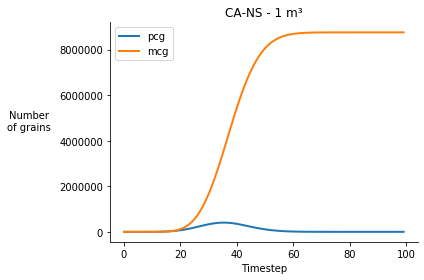

In [188]:
# Evoluton of number of pcg and mcg through timesteps
plt.plot(pcg_additions, lw=2, label="pcg")
plt.plot(mcg_evolution, lw=2, label="mcg")

# plt.vlines(85, 0, len(tester_array), color='k')
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.title("CA-NS - 1 m³")
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig("CA-NS_1m3_pcg-mcg_evolution.pdf")
plt.show();

In [176]:
total_pcg = 0
total_prob = 0

for array_pcg, array_prob in zip(pcgs_new, interface_constant_prob_new):
    total_pcg += array_pcg.shape[0]
    total_prob += array_prob.shape[0]
    
total_pcg
total_prob
tester_array.shape[0]

NameError: name 'interface_constant_prob_new' is not defined

In [389]:
np.array(np.split(np.array([0, 1, 3]), [1]))
np.array(np.split(np.array([0.25]), [0, 1]))[(0, 2),]

array([array([0]), array([1, 3])], dtype=object)

array([array([], dtype=float64), array([], dtype=float64)], dtype=object)

In [409]:
np.array([np.array([0]), np.array([1])]).reshape(2)

array([0, 1])

In [414]:
np.asarray([np.array([0]), np.array([1, 2])]).reshape(2)

array([array([0]), array([1, 2])], dtype=object)

In [374]:
np.split(np.array([0, 1, 2, 3, 4, 5]), [3])
np.array(np.split(np.array([0.25, 0.5, 0.75, 1, 1.25]), [2, 3]))[(0, 2),]

[array([0, 1, 2]), array([3, 4, 5])]

array([array([0.25, 0.5 ]), array([1.  , 1.25])], dtype=object)

____

## Old mechanical weathering code

___

In [54]:
def split_size(n):
    if n > 10:
        split_size = (0.9-0.1) * prng.random_sample() + 0.1
    else:
        a = 1/n
        b = 1 - a
        split_size = (b-a) * prng.random_sample() + a
    return split_size

In [7]:
def mechanical_weathering(steps):
    composition_new = [1]
    single_crystals = 0
    threshold = 1e-8

    for i in range(steps):
    #     print(composition_new)
        composition_old = composition_new
        composition_new = []

        for comp in composition_old:
            a, b = np.random.random(2)
    #         print(a, b)
            # Normalize and b
            sum_ = a + b
            a, b = a/sum_, b/sum_

            # Move fractions smaller than threshold to single crystals count
            for split in [a, b]:
                if split * comp <= threshold:
                    single_crystals += 1
                else:
                    composition_new += [split * comp]
    #         composition_new += [a*comp, b*comp] 

In [13]:
def mechanical_weathering_vectorized(steps, verbose=False, threshold=1e-8):
    """Threshold value is based on number of crystals that is expected to be 
    present in one cubic meter of parent rock which in turn is based on the average bulk crystal size
    
    Example:
    --------
    200 million crystals in 1 m³ means that a proportion of 0.5e-8 presents one crystal.
    When a proprtion is less than or equal to this threshold this would thus mean that 
    the pcg is no longer a pcg but has become a mcg.
    """
    composition_new = np.array([1])
    pcg_evolution = np.zeros(steps)
    mcg_evolution = np.zeros(steps)
    pcg_memory_usage = np.zeros(steps)
    single_crystals = 0

    for i in range(steps):
        composition_old = composition_new
        if verbose:
            print("composition_old", composition_old)
            print("composition_old_shape", composition_old.shape)
            
        # Obtain random fractions
        ab = np.random.random((2, composition_old.shape[0]))
        ab_norm = np.divide(ab, np.sum(ab, axis=0))
        if verbose:
            print("ab", ab)
            print("ab_norm", ab_norm)

        # Create new composition from old one and fractions
        composition_new = np.multiply(ab_norm.T, composition_old.reshape(-1, 1)).flatten()
        if verbose:
            print("composition_new", composition_new)
            print("composition_new_sum", np.sum(composition_new), "\n")
            
        # Move fractions smaller than threshold to single crystals count
        condition = composition_new <= threshold
        single_crystals += np.sum(condition)
        if verbose:
            print("single_crystals", single_crystals)
        composition_new = composition_new[~condition]
        
        if verbose:
            print("composition_new", composition_new)
            print("composition_new_sum", np.sum(composition_new), "\n")
        
        # Keep track of evolution of pcg and mcg
        pcg_evolution[i] = composition_new.shape[0]
        mcg_evolution[i] = single_crystals
        pcg_memory_usage[i] = composition_new.nbytes / 1024**2
        if composition_new.shape[0] == 0:
            print(i)
            break
        
    return composition_new, single_crystals, pcg_evolution, mcg_evolution, pcg_memory_usage

In [33]:
def mechanical_weathering_absolute_vectorized(steps, verbose=False, threshold=1, start_nr=200e6):
    """Threshold value is based on number of crystals that is expected to be 
    present in one cubic meter of parent rock which in turn is based on the average bulk crystal size
    
    Example:
    --------
    200 million crystals in 1 m³ means that a proportion of 0.5e-8 presents one crystal.
    When a proprtion is less than or equal to this threshold this would thus mean that 
    the pcg is no longer a pcg but has become a mcg.
    """
    composition = np.array([start_nr], dtype=np.uint32)
    pcg_evolution = np.zeros(steps, dtype=np.uint32)
    mcg_evolution = np.array([start_nr]*steps, dtype=np.uint32)
    pcg_memory_usage = np.zeros(steps, dtype=np.float64)
    single_crystals = 0

    for i in range(steps):
#         composition_old = composition_new
        if verbose:
            print("composition_old", composition)
            print("composition_old_shape", composition.shape)
            
        # Obtain random fractions to divide pcgs in two parts
        a_prop = np.random.random(composition.shape[0])
#         ab_norm = np.divide(ab, np.sum(ab, axis=0))
        if verbose:
            print("a_prop", a_prop)
#             print("ab_norm", ab_norm)

        # Create new composition from old one and fractions
        a = np.multiply(a_prop, composition).astype(np.uint32)
#         b = composition - a
        if verbose:
            print("a", a)
            print("b", composition - a)
        composition = np.array((a, composition - a))
        if verbose:
            print("composition_new", composition)
            print("composition_new_sum", np.sum(composition), "\n")
            
        # Move fractions smaller than threshold to single crystals count
        single_crystals += np.sum(composition == threshold)
        if verbose:
            print("single_crystals", single_crystals)
        # Remove single crystals and zero values from pcg array
        composition = composition[composition > threshold]
        
        if verbose:
            print("composition_new", composition)
            print("composition_new_sum", np.sum(composition), "\n")
        
        # Keep track of evolution of pcg and mcg numbers...
        pcg_evolution[i] = composition.shape[0]
        mcg_evolution[i] = single_crystals
        # ... and pcg_array memory usage
        pcg_memory_usage[i] = composition.nbytes / 1024**2
        
        # Break out of for loop if there are no more pcgs left
        if composition.shape[0] == 0:
            print(i)
            break
        
    return composition, single_crystals, pcg_evolution, mcg_evolution, pcg_memory_usage

In [34]:
%%time
tester2 = mechanical_weathering_absolute_vectorized(100, verbose=False, threshold=1, start_nr=200e6)

76
Wall time: 13 s


In [20]:
%%time
tester2 = mechanical_weathering_absolute_vectorized(100, verbose=False, threshold=1, start_nr=300e6)

80
Wall time: 29 s


In [212]:
%%time
tester2 = mechanical_weathering_absolute_vectorized(40, verbose=False, threshold=1, start_nr=200e6)

Wall time: 24.9 s


In [194]:
%%time
tester2 = mechanical_weathering_absolute_vectorized(40, verbose=False, threshold=1, start_nr=200e6)

Wall time: 35.6 s


In [185]:
%%time
tester2 = mechanical_weathering_absolute_vectorized(40, verbose=False, threshold=1, start_nr=200e6)

Wall time: 34.7 s


In [141]:
%%time
tester2 = mechanical_weathering_absolute_vectorized(40, verbose=False, threshold=1, start_nr=200e6)

Wall time: 1min 20s


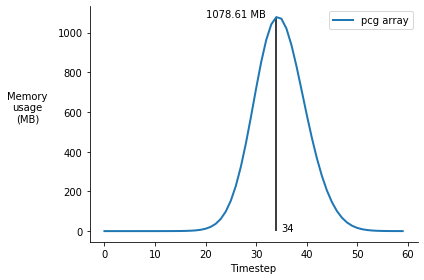

In [7]:
# Threshold set at 1e-9

# Memory usage of pcg array across timesteps
plt.plot(tester[4], lw=2, label='pcg array')
x_max = np.where(tester[4] == tester[4].max())[0][0]
y_max = tester[4].max()
# print(x_max, y_max)

# Annotate maximum memory usage
plt.annotate(f"{y_max:3.2f} MB", 
             (x_max, y_max),
             (20, y_max))
# Annotate timestep where maximum memory usage is reached
plt.annotate(x_max, 
             (x_max, 0),
             (x_max+1, 0))

plt.vlines(np.where(tester[4] == tester[4].max()), 0, tester[4].max())
plt.xlabel("Timestep")
plt.ylabel("Memory\nusage\n(MB)", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

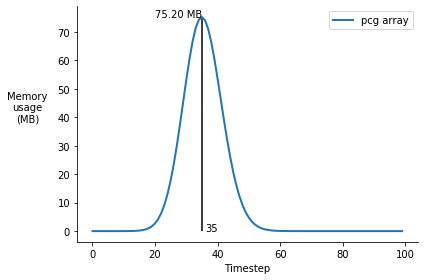

In [35]:
# Threshold set at 1, 200e6 crystals, unit32

tester = tester2

# Memory usage of pcg array across timesteps
plt.plot(tester[4], lw=2, label='pcg array')
x_max = np.where(tester[4] == tester[4].max())[0][0]
y_max = tester[4].max()
# print(x_max, y_max)

# Annotate maximum memory usage
plt.annotate(f"{y_max:3.2f} MB", 
             (x_max, y_max),
             (20, y_max))
# Annotate timestep where maximum memory usage is reached
plt.annotate(x_max, 
             (x_max, 0),
             (x_max+1, 0))

plt.vlines(np.where(tester[4] == tester[4].max()), 0, tester[4].max())
plt.xlabel("Timestep")
plt.ylabel("Memory\nusage\n(MB)", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

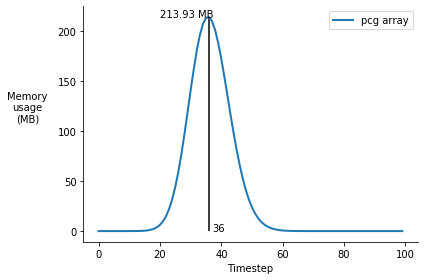

In [22]:
# Threshold set at 1, 300e6 crystals

tester = tester2

# Memory usage of pcg array across timesteps
plt.plot(tester[4], lw=2, label='pcg array')
x_max = np.where(tester[4] == tester[4].max())[0][0]
y_max = tester[4].max()
# print(x_max, y_max)

# Annotate maximum memory usage
plt.annotate(f"{y_max:3.2f} MB", 
             (x_max, y_max),
             (20, y_max))
# Annotate timestep where maximum memory usage is reached
plt.annotate(x_max, 
             (x_max, 0),
             (x_max+1, 0))

plt.vlines(np.where(tester[4] == tester[4].max()), 0, tester[4].max())
plt.xlabel("Timestep")
plt.ylabel("Memory\nusage\n(MB)", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

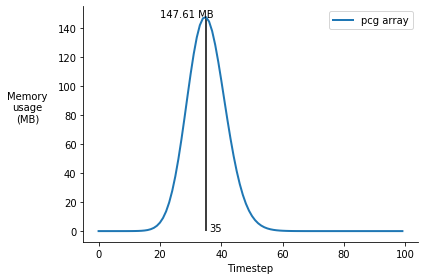

In [233]:
# Threshold set at 1, 200e6 crystals

tester = tester2

# Memory usage of pcg array across timesteps
plt.plot(tester[4], lw=2, label='pcg array')
x_max = np.where(tester[4] == tester[4].max())[0][0]
y_max = tester[4].max()
# print(x_max, y_max)

# Annotate maximum memory usage
plt.annotate(f"{y_max:3.2f} MB", 
             (x_max, y_max),
             (20, y_max))
# Annotate timestep where maximum memory usage is reached
plt.annotate(x_max, 
             (x_max, 0),
             (x_max+1, 0))

plt.vlines(np.where(tester[4] == tester[4].max()), 0, tester[4].max())
plt.xlabel("Timestep")
plt.ylabel("Memory\nusage\n(MB)", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

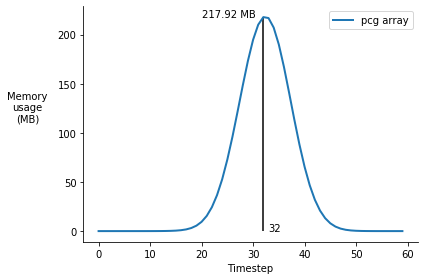

In [111]:
# Threshold set at 1e-8

# Memory usage of pcg array across timesteps
plt.plot(tester[4], lw=2, label='pcg array')
x_max = np.where(tester[4] == tester[4].max())[0][0]
y_max = tester[4].max()
# print(x_max, y_max)

# Annotate maximum memory usage
plt.annotate(f"{y_max:3.2f} MB", 
             (x_max, y_max),
             (20, y_max))
# Annotate timestep where maximum memory usage is reached
plt.annotate(x_max, 
             (x_max, 0),
             (x_max+1, 0))

plt.vlines(np.where(tester[4] == tester[4].max()), 0, tester[4].max())
plt.xlabel("Timestep")
plt.ylabel("Memory\nusage\n(MB)", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

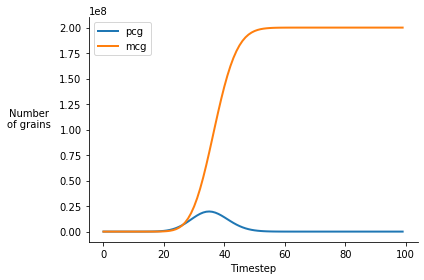

In [36]:
# Threshold set at 1, 200e6 crystals, unit32

tester = tester2

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

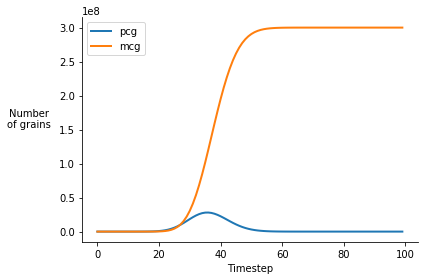

In [23]:
# Threshold set at 1, 300e6 crystals

tester = tester2

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

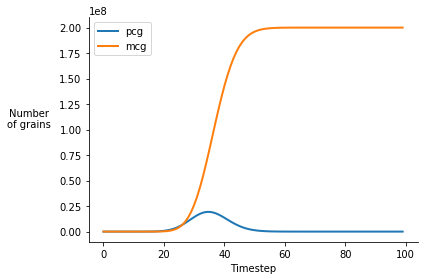

In [234]:
# Threshold set at 1, 200e6 crystals

tester = tester2

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

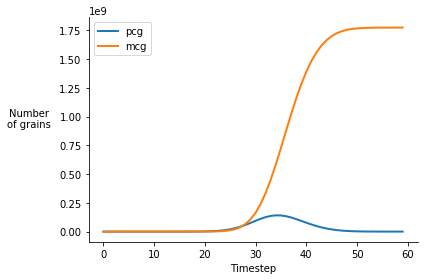

In [8]:
# Threshold set at 1e-9

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

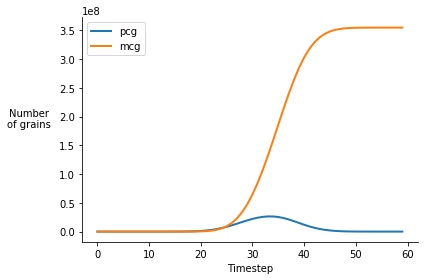

In [85]:
# Threshold set at 1e-8

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

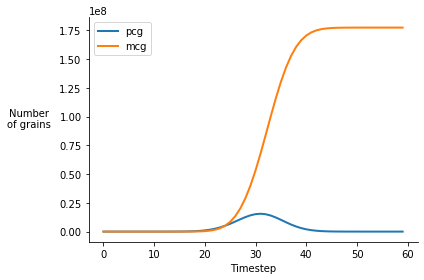

In [82]:
# Threshold set at 2e-8

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

___